# Import needed libraries & adjust output settings

In [1]:
#standard need libraries
import pandas as pd
import numpy as np

#libraries to scrape CAVA locations website
import requests
from bs4 import BeautifulSoup as bsoup

#import library for manipulating json files
import json

#library to get coordinates from city name
from opencage.geocoder import OpenCageGeocode

print('\nLibraries imported\n')


Libraries imported



In [2]:
## Set to show all rows and columns in a dataset
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print('\nOption set to display all dataframe rows and columns.\n')


Option set to display all dataframe rows and columns.



#### 

# Make dataframe of location info for CAVA zip codes

In [ ]:
#### Scrape html doc with CAVA location info from website

In [3]:
response = requests.get('https://cava.com/locations')

## Check that get attempt worked by printing a few lines
print(response.text[0:250])

## Make a beautiful soup object with parsed html
cava_soup = bsoup(response.text, 'html.parser')

<!DOCTYPE html>
<html class="no-js" lang="en">
  <head>
    <meta charset="utf-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="google-site-verification" content="4JONUyauKNrbInlgD43lCmhqWL23ad_-iaED1TjQE3A" />
    <title


In [ ]:
#### Get all html blocks that have location info for CAVA restaurants

In [4]:
cava_locs_soup = cava_soup.find_all('div', class_ = 'adr copy')

## See how many CAVA locations there are
print('\nNumber of CAVA sites: ', len(cava_locs_soup), '\n', sep = '')

## Show structure of info for first listed CAVA location (to know who to extract info)
print(cava_locs_soup[0].prettify())


Number of CAVA sites: 105

<div class="adr copy">
 <div class="street-address">
  8162 East Santa Ana Canyon Rd
 </div>
 <span class="locality">
  Anaheim
 </span>
 ,
 <span class="region">
  CA
 </span>
 <span class="postal-code">
  92808
 </span>
 <div>
  <a href="tel:714-782-7478" title="Call Anaheim Hills">
   714-782-7478
  </a>
 </div>
</div>



In [ ]:
#### Extract info for first listed CAVA location to check that it's possible

In [5]:
locality = cava_locs_soup[0].find('span', class_ = 'locality').text
state = cava_locs_soup[0].find('span', class_ = 'region').text
address = cava_locs_soup[0].find('div', class_ = 'street-address').text
postal_code = cava_locs_soup[0].find('span', class_ = 'postal-code').text

print('\nFirst Location:\n\n',
      locality, ', ', state, '\n',
      address, ', ', postal_code, '\n',
      sep = '')


First Location:

Anaheim, CA
8162 East Santa Ana Canyon Rd, 92808



In [ ]:
#### Get list of needed info for all CAVA locations

In [6]:
## Initialize a list to store all info in format for conversion to dataframe
cava_info_list = []

## Add info for each CAVA site to list
for cava in cava_locs_soup:    
    
    city = cava.find('span', class_ = 'locality').text
    state = cava.find('span', class_ = 'region').text
    postal_code = cava.find('span', class_ = 'postal-code').text

    cava_info_list.append([postal_code, ', '.join([city , state])])

## Check that list has info for every CAVA: 105 expected
print('\nExpected number of CAVA locations: 105')
print('Length of loc info list: ', len(cava_info_list), '\n', sep = '')    

print('Sample locations:')
for city in cava_info_list[0:10]:
    print(city)
print('\n')


Expected number of CAVA locations: 105
Length of loc info list: 105

Sample locations:
['92808', 'Anaheim, CA']
['92627', 'Costa Mesa, CA']
['90232', 'Culver City, CA']
['92130', 'San Diego, CA']
['92024', 'Encinitas, CA']
['92606', 'Irvine, CA']
['92037', 'La Jolla, CA']
['92108', 'San Diego, CA']
['92691', 'Mission Viejo, CA']
['91101', 'Pasadena, CA']




In [ ]:
#### Convert info list to dataframe and add needed info

In [7]:
## Convert list to dataframe
cava_loc_info_df = pd.DataFrame(cava_info_list, columns = ['Zip Code', 'City'])

## Fix entry errors found in course of development
cava_loc_info_df.loc[47, 'City'] = 'Raleigh, NC'

for i, row in cava_loc_info_df.iterrows():
    if row['City'].split(',')[-1] == ' VA ':
        row['City'] = row['City'].split(',')[0] + ', VA'
        
## Drop duplicate rows (because some zip codes might have more than 1 CAVA)
cava_loc_info_df.drop_duplicates(inplace = True)

print('\nDataframe Shape: \n', cava_loc_info_df.shape, '\n', sep = '')
cava_loc_info_df.sort_values(by = 'Zip Code').head()


Dataframe Shape: 
(101, 2)



,Zip Code,City
30,02026,"Dedham, MA"
32,02043,"Hingham, MA"
29,02116,"Boston, MA"
33,02142,"Cambridge, MA"
31,02215,"Boston, MA"


In [8]:
## Add variables for coordinates
cava_loc_info_df['Latitude'] = ["NA"] * len(cava_loc_info_df)
cava_loc_info_df['Longitude'] = ["NA"] * len(cava_loc_info_df)

## Get coordinates for each zip code
zip_geocoder = OpenCageGeocode(key = '2cc2ff6d1fa14099b8a24d469f4fd038')

total = len(cava_loc_info_df)
completed = 0

for i, row in cava_loc_info_df.iterrows():
    
    input_address = ', '.join([row['City'].split(',')[-1], row['Zip Code']])
    
    location = zip_geocoder.geocode(query = input_address)
    row['Latitude'] = location[0]['geometry']['lat']
    row['Longitude'] = location[0]['geometry']['lng']
    
    completed += 1
    print('Percent completed: {:%}'.format(completed/total), end = '\r')

## Add variable to record whether zip code has CAVA
columns = cava_loc_info_df.columns.tolist()
cava_loc_info_df['Has CAVA?'] = [1] * len(cava_loc_info_df)
cava_loc_info_df = cava_loc_info_df[['Has CAVA?'] + columns]

## Visualize dataframe
print('\n\nDataframe Shape: \n', cava_loc_info_df.shape, '\n', sep = '')
cava_loc_info_df.sort_values(by = 'Zip Code').head()

Percent completed: 100.000000%

Dataframe Shape: 
(101, 5)



,Has CAVA?,Zip Code,City,Latitude,Longitude
30,1,02026,"Dedham, MA",42.2461,-71.1635
32,1,02043,"Hingham, MA",42.2214,-70.8991
29,1,02116,"Boston, MA",42.3488,-71.0813
33,1,02142,"Cambridge, MA",42.3641,-71.0834
31,1,02215,"Boston, MA",42.348,-71.0887


In [ ]:
#### Save dataframe for later use

In [9]:
cava_loc_info_df.to_csv('/Users/mitchelllee/cava_loc_info_df')

print('\nDataframe saved.')


Dataframe saved.


#### 

# Make dataframe of location info for non-CAVA zip codes in states with CAVA

In [ ]:
#### Load in dataframe with info for zip codes with CAVAs saved on personal compuer

In [10]:
## Read in dataset
cava_loc_info_df = pd.read_csv('/Users/mitchelllee/cava_loc_info_df', dtype = {'Zip Code' : str}).drop('Unnamed: 0', axis = 1)

print('\nDataframe shape: ', cava_loc_info_df.shape, '\n', sep = '')
cava_loc_info_df.sort_values(by = 'Zip Code').head()


Dataframe shape: (101, 5)



,Has CAVA?,Zip Code,City,Latitude,Longitude
28,1,02026,"Dedham, MA",42.246102,-71.163457
30,1,02043,"Hingham, MA",42.221369,-70.899076
27,1,02116,"Boston, MA",42.348773,-71.081297
31,1,02142,"Cambridge, MA",42.364141,-71.083428
29,1,02215,"Boston, MA",42.347993,-71.088745


In [ ]:
#### Get list of states with CAVA

In [11]:
## Get list of cities (including state abbreviations) that have CAVA
cava_cities = set(cava_loc_info_df['City'])
cava_states = []

## For each city, add state abbreviation to list (will remove duplicates with later set function)
for city in cava_cities:
    cava_states.append(city.split(', ')[-1])

## #liminate duplicates and ignore DC because we won't be putting any new CAVAs in DC (because it already has so many)
cava_states = list(set(cava_states) - set(['DC']))
cava_states.sort()
print('\nStates with CAVA: {}'.format(cava_states), '\n')


States with CAVA: ['CA', 'CO', 'CT', 'MA', 'MD', 'NC', 'NJ', 'NY', 'PA', 'TN', 'TX', 'VA'] 



In [ ]:
#### Get list of zip codes with CAVA

In [12]:
## Get list of cities with CAVA locations
cava_zips = set(cava_loc_info_df['Zip Code'])

## Show some of the zip codes to confirm code worked
print('\nSome zip codes with CAVA:\n\n{}'.format(list(cava_zips)[0:10]), '\n', sep = '')


Some zip codes with CAVA:

['22015', '23320', '22202', '90089', '91101', '22101', '90401', '11201', '80031', '27511']



In [ ]:
#### Make dataframe of postal codes without CAVA (in states with CAVAs)

In [13]:
## Initialize the overall dataframe
nocava_loc_info_df = pd.DataFrame(columns=['Zip Code', 'City'])

## Create state abbreviation dictionary from internet
states_abbvs_dict = {
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'NC': 'North Carolina',
        'NJ': 'New Jersey',
        'NY': 'New York',
        'PA': 'Pennsylvania',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'VA': 'Virginia'
}

## Define variables to report progress through code
completed = 0
total = len(cava_states)

## For each state, make dataframe of largest non-CAVA zip codes by population
for state in cava_states:
    
    ## Get zip codes in state with biggest populations
    # write state name in format appropriate for url (use dict to get full state name, remove any spaces, then make lowercase)
    state_name_v1 = ''.join(states_abbvs_dict[state].split(' ')).lower() #use states dict to get full state name, remove any spaces, then make lowercase (for use to find url)
    # read in table from the url
    zips = pd.read_html('https://www.{}-demographics.com/zip_codes_by_population'.format(state_name_v1))[0]['Zip Code'][0:30].astype(str).tolist()          
    # remove zip codes that already have CAVA
    nocava_zips = list(set(zips) - set(cava_zips))      
    # make into dataframe
    nocava_zips_df = pd.DataFrame(nocava_zips, columns=['Zip Code']).reset_index().drop('index', axis =1)
    nocava_zips_df['Zip Code'] = nocava_zips_df['Zip Code'].astype(str)

    ## Get city associated with zip code in current state
    # write state name in format appropriate for url
    state_name_v2 = '%20'.join(states_abbvs_dict[state].split(' '))
    # read in table from the url
    cits_df = pd.read_html('https://www.zipcodestogo.com/{}/'.format(state_name_v2))[1].iloc[2:,0:2].reset_index().drop('index', axis = 1)
    # relabel columns for easier referencing
    cits_df.columns = ['Zip Code', 'City']
    # make zip codes type: str
    cits_df['Zip Code'] = cits_df['Zip Code'].astype(str)
    # add state abbreviation to city names
    cits_df['City'] = cits_df['City'] + ', ' + state
    
    ## Merge 'no_cava_postals_df' and 'cits_df'
    nocava_zips_df = nocava_zips_df.merge(cits_df, on = 'Zip Code')
    
    ## Add state-specific dataframe to overall dataframe with append method
    nocava_loc_info_df = nocava_loc_info_df.append(nocava_zips_df)
    
    completed += 1
    print('Percent completed: {:%}'.format(completed/total), end = '\r')


print('\n\nDataframe shape: ', nocava_loc_info_df.shape, '\n', sep = '')
nocava_loc_info_df.head()

Percent completed: 100.000000%

Dataframe shape: (345, 2)



,Zip Code,City
0,91744,"La Puente, CA"
1,93033,"Oxnard, CA"
2,92154,"San Diego, CA"
3,92503,"Riverside, CA"
4,93727,"Fresno, CA"


In [ ]:
#### Add coordinates and CAVA designation ('doesn't have') to dataframe

In [14]:
## Reset 'nocava_loc_df' index and drop old indexing from sub dataframes
nocava_loc_info_df = nocava_loc_info_df.reset_index().drop('index', axis = 1)
nocava_loc_info_df['Latitude'] = ['NA'] * len(nocava_loc_info_df)
nocava_loc_info_df['Longitude'] = ['NA'] * len(nocava_loc_info_df)
nocava_loc_info_df['Has CAVA?'] = 0 * len(nocava_loc_info_df)

## Assign 'Has CAVA' variable to 'No'
nocava_loc_info_df['Has CAVA?'] = [0] * len(nocava_loc_info_df)

## Get coordinates for each zip code
zip_geocoder = OpenCageGeocode(key = '2cc2ff6d1fa14099b8a24d469f4fd038')

total_items = len(nocava_loc_info_df)
completed_items = 0

for i, row in nocava_loc_info_df.iterrows():
    
    # format address of row appropriately
    input_address = ', '.join([row['City'].split(',')[-1], row['Zip Code']])

    # make query
    location = zip_geocoder.geocode(query = input_address)
    nocava_loc_info_df.loc[i, 'Latitude'] = location[0]['geometry']['lat']
    nocava_loc_info_df.loc[i, 'Longitude'] = location[0]['geometry']['lng']
    
    completed_items += 1
    print('Percent remaining: {:%}'.format(completed_items/total_items), end = '\r')


nocava_loc_info_df = nocava_loc_info_df[['Has CAVA?','Zip Code','City','Latitude','Longitude']]    
    
print('\nDataframe shape: ', nocava_loc_info_df.shape, '\n')
nocava_loc_info_df.sort_values(by = 'Zip Code').head()

Percent remaining: 100.000000%
Dataframe shape:  (345, 5) 



,Has CAVA?,Zip Code,City,Latitude,Longitude
102,0,01040,"Holyoke, MA",42.2034,-72.6245
111,0,01085,"Westfield, MA",42.0967,-72.7402
106,0,01201,"Pittsfield, MA",42.454,-73.2475
94,0,01420,"Fitchburg, MA",42.5758,-71.8024
108,0,01453,"Leominster, MA",42.5083,-71.7468


In [ ]:
#### Save dataframe to personal computer for later use (so that entire notebook does not have to be run each time)

In [15]:
nocava_loc_info_df.to_csv('/Users/mitchelllee/nocava_loc_info_df')
print('\nDataframe saved.')


Dataframe saved.


#### 

# Combine CAVA and non-CAVA info dataframes

In [ ]:
##### Load 'cava_loc_info_df'

In [16]:
## Load dataframe
cava_loc_info_df = pd.read_csv('/Users/mitchelllee/cava_loc_info_df', dtype = {'Zip Code':str}).drop('Unnamed: 0', axis = 1)

## Show dataframe
print('\nDataframe shape: ', cava_loc_info_df.shape, '\n', sep = '')
cava_loc_info_df.head()


Dataframe shape: (101, 5)



,Has CAVA?,Zip Code,City,Latitude,Longitude
0,1,92808,"Anaheim, CA",33.858427,-117.707739
1,1,92627,"Costa Mesa, CA",33.637937,-117.921739
2,1,90232,"Culver City, CA",34.019962,-118.399337
3,1,92130,"San Diego, CA",32.962655,-117.189656
4,1,92024,"Encinitas, CA",33.044445,-117.280409


In [ ]:
#### Load 'nocava_loc_info_df'

In [17]:
## Load dataframe
nocava_loc_info_df = pd.read_csv('/Users/mitchelllee/nocava_loc_info_df', dtype = {'Zip Code':str}).drop('Unnamed: 0', axis = 1)

## Show dataframe
print('\nDataframe shape: ', nocava_loc_info_df.shape, '\n', sep = '')
nocava_loc_info_df.head()


Dataframe shape: (345, 5)



,Has CAVA?,Zip Code,City,Latitude,Longitude
0,0,91744,"La Puente, CA",34.039617,-117.949799
1,0,93033,"Oxnard, CA",34.169617,-119.168585
2,0,92154,"San Diego, CA",32.584207,-117.085970
3,0,92503,"Riverside, CA",33.912244,-117.444177
4,0,93727,"Fresno, CA",36.737886,-119.697247


In [ ]:
#### Combine 'cava_loc_info_df' & 'nocava_loc_info_df' into one dataframe

In [19]:
## Use append method to combine dataframes
combined_loc_info_df = cava_loc_info_df.append(nocava_loc_info_df).reset_index().drop(['index'], axis = 1)
combined_loc_info_df.drop_duplicates(inplace = True)

## Find expected dataframe size
print('\nExpected dataframe shape: ({}, {})'.format(len(cava_loc_info_df) + len(nocava_loc_info_df), len(cava_loc_info_df.columns)))

## Show dataframe and its shape
print('\nDataframe shape: ', combined_loc_info_df.shape, '\n', sep = '')
combined_loc_info_df.sort_values(by = 'City').head()


Expected dataframe shape: (446, 5)

Dataframe shape: (446, 5)



,Has CAVA?,Zip Code,City,Latitude,Longitude
92,1,22305,"Alexandria, VA",38.838504,-77.065392
75,1,22314,"Alexandria, VA",38.805057,-77.050220
76,1,22315,"Alexandria, VA",38.759248,-77.158834
437,0,22304,"Alexandria, VA",38.810080,-77.089191
342,0,18104,"Allentown, PA",40.601743,-75.498102


In [ ]:
#### Write dataset to csv file stored on computer for permanent access of later stages

In [20]:
combined_loc_info_df.to_csv('/Users/mitchelllee/cava_combo_loc_info_df')
print('\nDataframe saved.')


Dataframe saved.


#### 

# Get dataframe of venues around each zip code in training dataframe

In [ ]:
#### Read in location info dataset from personal computer

In [21]:
## Read in dataframe
combined_loc_info_df = pd.read_csv('/Users/mitchelllee/cava_combo_loc_info_df', dtype = {'Zip Code':str}).drop('Unnamed: 0', axis = 1)

## Show dataframe
print('\nDataframe shape: ', combined_loc_info_df.shape, '\n', sep = '')
combined_loc_info_df.sort_values(by = 'City').head()


Dataframe shape: (446, 5)



,Has CAVA?,Zip Code,City,Latitude,Longitude
92,1,22305,"Alexandria, VA",38.838504,-77.065392
75,1,22314,"Alexandria, VA",38.805057,-77.050220
76,1,22315,"Alexandria, VA",38.759248,-77.158834
437,0,22304,"Alexandria, VA",38.810080,-77.089191
342,0,18104,"Allentown, PA",40.601743,-75.498102


In [ ]:
#### Define credentials and version for foursquare

In [22]:
CLIENT_ID = 'C5TVLNNOZ3QX14URLNVGVXAKYHOT421V0KR21MSGVJY1O2CR' # my Foursquare ID
CLIENT_SECRET = 'BCTZ4WTEUPUZWKQO0RBRZQZUJ3QDSXV1Y2BKIW5VGUP32M2H' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('\nCredentials defined.\n')


Credentials defined.



In [ ]:
#### Define function to get venues for each postal code in 'combined_loc_info_df' using 'explore' endpoint

In [23]:
### ### ###
def getNearbyVenuesExplore(desigs, cities, postals, latitudes, longitudes, radius, LIMIT):
    
    venues_list=[]
    
    total = len(desigs)
    completed = 0
    
    for desig, city, postal, lat, lng in zip(desigs, cities, postals, latitudes, longitudes):

        ## Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
        
        try: # to account for empty 'response' returns
            results = requests.get(url).json()['response']['groups'][0]['items']
        except KeyError:
            results = []
        
        ## Return only relevant information for each nearby venue
        for v in results:
            try: # to account for venue returns with empty 'category'
                venues_list.append([desig,
                                        city,
                                        postal,
                                        lat,
                                        lng,
                                        v['venue']['name'],
                                        v['venue']['categories'][0]['name']])
            except KeyError:
                pass

        ## Show progress as percentage of 'result' output processed
        completed += 1
        print('Percent completed: {:%}'.format(completed/total), end = '\r')
        

    ## Make 'venues_list' into a dataframe        
    nearby_vens = pd.DataFrame(venues_list)
    nearby_vens.columns = ['Has CAVA?',
                           'City',
                           'Zip Code',
                           'Latitude',
                           'Longitude',
                           'Venue',
                           'Venue Category']
    
    return(nearby_vens)

### ### ###

In [ ]:
#### Use function 'getNearbyVenuesExplore' to get venues for each postal code in 'combined_loc_info_df' using 'explore' endpoint

In [24]:
## Run function for 'combined_loc_info_df'
near_vens_df = getNearbyVenuesExplore(combined_loc_info_df['Has CAVA?'],
                                      combined_loc_info_df['City'],
                                      combined_loc_info_df['Zip Code'],
                                      combined_loc_info_df['Latitude'],
                                      combined_loc_info_df['Longitude'],
                                      3200,
                                      100
                                     )
## Drop any duplicates
near_vens_df.drop_duplicates(inplace = True)


## Show dataframe and its shape
print('\r                                                          ')
print('Processing complete.')
print('\nDataframe shape: ', near_vens_df.shape, '\n', sep = '')   
near_vens_df.head()

                                                          
Processing complete.

Dataframe shape: (31306, 7)



,Has CAVA?,City,Zip Code,Latitude,Longitude,Venue,Venue Category
0,1,"Anaheim, CA",92808,33.858427,-117.707739,Ronald Reagan Park,Park
1,1,"Anaheim, CA",92808,33.858427,-117.707739,The Rinks Yorba Linda Ice,Skating Rink
2,1,"Anaheim, CA",92808,33.858427,-117.707739,Rosine's Mediterranean Grill,Mediterranean Restaurant
3,1,"Anaheim, CA",92808,33.858427,-117.707739,Michaels,Arts & Crafts Store
4,1,"Anaheim, CA",92808,33.858427,-117.707739,Wahoo's Fish Taco,Mexican Restaurant


In [ ]:
##### Eliminate rows corresponding to a CAVA (don't want to include CAVA as a parameter when training to predict CAVA success)

In [25]:
## Record dataframe shape before dropping CAVA locations
pre_drop_shape = near_vens_df.shape

## Make all entries for 'Venue' lowercase to better homogenize for elimination of anything containing 'cava'
near_vens_df['Venue'] = near_vens_df['Venue'].str.lower()

## Eliminate any row where 'Venue' is related to CAVA (as determined by containing 'cava')
for i, row in near_vens_df.iterrows():
    if row['Venue'] in ['cava', 'cava grill', 'cava mezze']:
        near_vens_df.drop(i, inplace = True)

## Record dataframe shape after drop
post_drop_shape = near_vens_df.shape

## Check that rows where 'Venue' contains 'cava' are eliminated
print('\nDataframe shape before dropping returned CAVA locations: {}'.format(pre_drop_shape))
print('Dataframe shape after dropping returned CAVA locations: {}'.format(post_drop_shape))
print('Number of rows dropped: {}'.format(pre_drop_shape[0] - post_drop_shape[0]), '\n')

near_vens_df[near_vens_df['Venue'].str.startswith('cav')].sort_values(by = 'Venue')


Dataframe shape before dropping returned CAVA locations: (31306, 7)
Dataframe shape after dropping returned CAVA locations: (31245, 7)
Number of rows dropped: 61 



,Has CAVA?,City,Zip Code,Latitude,Longitude,Venue,Venue Category
23539,0,"Bloomfield, NJ",07003,40.807962,-74.187466,cavallo's market,Italian Restaurant
1168,1,"Woodland Hills, CA",91367,34.179980,-118.599510,cavaretta's italian groceries,Deli / Bodega
18440,0,"Owings Mills, MD",21117,39.455141,-76.727742,caves valley golf club,Golf Course
18443,0,"Owings Mills, MD",21117,39.455141,-76.727742,caves valley historic district,Historic Site


In [ ]:
#### Show number of nearby venues for each zip code  

In [26]:
## Group venues dataframe by zip code to see number of each venue type in each zip code
near_vens_grouped_df = near_vens_df.groupby(by = 'Zip Code').count().reset_index()[['Zip Code','City']]
near_vens_grouped_df.columns = ['Zip Code','Number of Venues']

## Find number of zip codes with no returned values
no_ven_zips = set(combined_loc_info_df['Zip Code']) - set(near_vens_grouped_df['Zip Code'])

print('\nNumber of postal codes searched for venues: {}'.format(len(combined_loc_info_df)))
print('Number of postal codes with no returned venues: {}'.format(len(no_ven_zips)), sep = '') 

## Show zip codes that had no returns
print('\nZip codes with no returned venues:\n')
if len(no_ven_zips) == 0:
    print("None\n")
else:
    for post in no_ven_zips:
        print(post)

## Confirm dataframe is as expected
print('\nExpected # rows in new dataframe: {}'.format(len(combined_loc_info_df) - len(no_ven_zips)), sep = '') # add four because 'combined_loc_info_df' contains ['Has CAVA?', 'City', 'Latitude','Longitude']
print('Dataframe shape: ', near_vens_grouped_df.shape, '\n', sep = '')
near_vens_grouped_df.head()


Number of postal codes searched for venues: 446
Number of postal codes with no returned venues: 0

Zip codes with no returned venues:

None


Expected # rows in new dataframe: 446
Dataframe shape: (446, 2)



,Zip Code,Number of Venues
0,01040,64
1,01085,59
2,01201,71
3,01420,53
4,01453,63


In [ ]:
#### Save venue dataset to personal computer

In [27]:
near_vens_df.to_csv('/Users/mitchelllee/cava_uncoded_venue_df')
print('\nDataset saved.\n')


Dataset saved.



#### 

# Code venue types in dataset cities (for later ML classifiers)

In [ ]:
#### Read venue dataset into environment from personal computer

In [28]:
near_vens_df = pd.read_csv('/Users/mitchelllee/cava_uncoded_venue_df', dtype = {'Zip Code':str}).drop('Unnamed: 0', axis = 1)

print('\nDataframe shape: ', near_vens_df.shape, '\n', sep = '')
near_vens_df.sort_values(by = 'Zip Code').head()


Dataframe shape: (31245, 7)



,Has CAVA?,City,Zip Code,Latitude,Longitude,Venue,Venue Category
15939,0,"Holyoke, MA",01040,42.203372,-72.624506,motel 6 holyoke ma,Hotel
15933,0,"Holyoke, MA",01040,42.203372,-72.624506,kfc,Fried Chicken Joint
15932,0,"Holyoke, MA",01040,42.203372,-72.624506,fitzpatrick ice skating rink,Skating Rink
15931,0,"Holyoke, MA",01040,42.203372,-72.624506,jenrose liquors,Liquor Store
15930,0,"Holyoke, MA",01040,42.203372,-72.624506,sláinte,American Restaurant


In [ ]:
#### Get raw dummy coding dataset

In [29]:
#performing coding for number of each type of venue around each CAVA site
near_vens_onehot_df = pd.get_dummies(near_vens_df[['Venue Category']], prefix = "", prefix_sep="")
near_vens_onehot_df['Zip Code'] = near_vens_df['Zip Code']

ord_cols = list(set(near_vens_onehot_df.columns.tolist()) - set(['Zip Code']))

near_vens_onehot_df = near_vens_onehot_df[['Zip Code'] + ord_cols]

print('\nDataframe shape: ', near_vens_onehot_df.shape, '\n', sep = '')
near_vens_onehot_df.sort_values(by = 'Zip Code').head()


Dataframe shape: (31245, 496)



,Zip Code,Modern European Restaurant,Harbor / Marina,Ski Lodge,Stadium,Bike Shop,Argentinian Restaurant,New American Restaurant,Forest,Track,Tanning Salon,Light Rail Station,Taiwanese Restaurant,Caribbean Restaurant,Used Bookstore,Pizza Place,Medical Center,Recreation Center,Brewery,Eye Doctor,Cocktail Bar,Food Service,Gas Station,Pet Store,Gym / Fitness Center,Resort,Zoo Exhibit,Grocery Store,Radio Station,ATM,Pub,Travel Agency,Video Store,Food Court,Beer Garden,Dive Bar,Smoke Shop,Salon / Barbershop,Airport Lounge,Indie Movie Theater,Cheese Shop,Gourmet Shop,Toy / Game Store,Empanada Restaurant,Rental Car Location,Basketball Stadium,Gay Bar,Library,Scandinavian Restaurant,Escape Room,Bookstore,Hawaiian Restaurant,Malay Restaurant,Market,Rental Service,College Rec Center,Strip Club,Gaming Cafe,Laundry Service,Heliport,Climbing Gym,Golf Driving Range,Convenience Store,Spa,Hookah Bar,Construction & Landscaping,Tailor Shop,Afghan Restaurant,Bistro,Candy Store,Shoe Store,Spanish Restaurant,Marijuana Dispensary,Fish Market,Japanese Restaurant,Train Station,Bank,Outlet Store,Playground,Print Shop,Laser Tag,Vietnamese Restaurant,Paintball Field,Coffee Shop,Arepa Restaurant,Thai Restaurant,Paella Restaurant,Event Service,College Theater,College Quad,South Indian Restaurant,Intersection,Flea Market,Toll Booth,Whisky Bar,Dessert Shop,Hotel Bar,Smoothie Shop,Cemetery,Chocolate Shop,Cafeteria,Other Repair Shop,Airport Service,Park,Jewish Restaurant,Courthouse,Kebab Restaurant,Music Venue,Dim Sum Restaurant,College Basketball Court,School,Mountain,Department Store,Baseball Field,Pharmacy,College Administrative Building,Supplement Shop,Hotel,Massage Studio,University,Cajun / Creole Restaurant,Fondue Restaurant,Outlet Mall,Bubble Tea Shop,Middle School,Deli / Bodega,Winery,Roof Deck,College Gym,Golf Course,Martial Arts School,Museum,Arts & Entertainment,Hot Dog Joint,North Indian Restaurant,Butcher,Community Center,Lake,Italian Restaurant,Go Kart Track,Fast Food Restaurant,Baby Store,Mattress Store,Parking,Juice Bar,Private School,Baseball Stadium,Recycling Facility,Vape Store,Soccer Field,Roller Rink,Yoga Studio,Churrascaria,Farmers Market,Dog Run,Boxing Gym,Home Service,Falafel Restaurant,Skating Rink,Dry Cleaner,Kids Store,Opera House,Stables,Sculpture Garden,Planetarium,Food & Drink Shop,Hunting Supply,Soup Place,Tattoo Parlor,Theme Park Ride / Attraction,Herbs & Spices Store,Mediterranean Restaurant,Factory,Distillery,Volleyball Court,Paper / Office Supplies Store,Ethiopian Restaurant,Tapas Restaurant,Discount Store,Liquor Store,Shopping Mall,Neighborhood,Electronics Store,Science Museum,Chaat Place,Theme Restaurant,Public Art,Beer Store,Latin American Restaurant,Fish & Chips Shop,Indonesian Restaurant,Indian Restaurant,Spiritual Center,Theme Park,Furniture / Home Store,Organic Grocery,Rest Area,Veterinarian,Airport,College Auditorium,Men's Store,Nightclub,Moving Target,Fair,Medical Supply Store,Cantonese Restaurant,Pet Café,Noodle House,Recording Studio,Asian Restaurant,Airport Terminal,Fried Chicken Joint,Garden,French Restaurant,Motorcycle Shop,Gastropub,Truck Stop,Flower Shop,Trail,Turkish Restaurant,Waterfront,German Restaurant,Gift Shop,Wine Bar,Wings Joint,Bridge,Szechuan Restaurant,River,Hunan Restaurant,Boarding House,Business Service,Ice Cream Shop,Street Food Gathering,College Classroom,Field,Bowling Alley,Wine Shop,Middle Eastern Restaurant,Mini Golf,Clothing Store,Gymnastics Gym,Check Cashing Service,Halal Restaurant,Record Shop,Jewelry Store,Outdoors & Recreation,Insurance Office,Nature Preserve,Post Office,Office,Art Museum,Rock Club,Soccer Stadium,Arcade,Brazilian Restaurant,Video Game Store,General Travel,Leather Goods Store,Bridal Shop,Capitol Building,Optical Shop,Outdoor Supply Store,Bike Trail,Surf Spot,Border Crossing,South American Restaurant,Car Wash,Donut Shop,Coworking Space,Photography Studio,Cuban Restaurant,Colombian Restaurant,Pedestrian Plaza,Health & Beauty Service,Belgian Restaurant,Street Art,Lawyer,Sh

In [ ]:
#### Group dummied dataset by zip code and show total number of each venue type

In [30]:
try: #sometimes a 'City' variable is returned by the 'explore' endpoint
    near_vens_onehot_grouped_df = near_vens_onehot_df.groupby(by = 'Zip Code').sum().reset_index().drop('City', axis = 1)
except KeyError:
    near_vens_onehot_grouped_df = near_vens_onehot_df.groupby(by = 'Zip Code').sum().reset_index()
    
print('\nDataframe shape: ', near_vens_onehot_grouped_df.shape, '\n', sep = '')
near_vens_onehot_grouped_df.sort_values(by = 'Zip Code').head()


Dataframe shape: (446, 496)



,Zip Code,Modern European Restaurant,Harbor / Marina,Ski Lodge,Stadium,Bike Shop,Argentinian Restaurant,New American Restaurant,Forest,Track,Tanning Salon,Light Rail Station,Taiwanese Restaurant,Caribbean Restaurant,Used Bookstore,Pizza Place,Medical Center,Recreation Center,Brewery,Eye Doctor,Cocktail Bar,Food Service,Gas Station,Pet Store,Gym / Fitness Center,Resort,Zoo Exhibit,Grocery Store,Radio Station,ATM,Pub,Travel Agency,Video Store,Food Court,Beer Garden,Dive Bar,Smoke Shop,Salon / Barbershop,Airport Lounge,Indie Movie Theater,Cheese Shop,Gourmet Shop,Toy / Game Store,Empanada Restaurant,Rental Car Location,Basketball Stadium,Gay Bar,Library,Scandinavian Restaurant,Escape Room,Bookstore,Hawaiian Restaurant,Malay Restaurant,Market,Rental Service,College Rec Center,Strip Club,Gaming Cafe,Laundry Service,Heliport,Climbing Gym,Golf Driving Range,Convenience Store,Spa,Hookah Bar,Construction & Landscaping,Tailor Shop,Afghan Restaurant,Bistro,Candy Store,Shoe Store,Spanish Restaurant,Marijuana Dispensary,Fish Market,Japanese Restaurant,Train Station,Bank,Outlet Store,Playground,Print Shop,Laser Tag,Vietnamese Restaurant,Paintball Field,Coffee Shop,Arepa Restaurant,Thai Restaurant,Paella Restaurant,Event Service,College Theater,College Quad,South Indian Restaurant,Intersection,Flea Market,Toll Booth,Whisky Bar,Dessert Shop,Hotel Bar,Smoothie Shop,Cemetery,Chocolate Shop,Cafeteria,Other Repair Shop,Airport Service,Park,Jewish Restaurant,Courthouse,Kebab Restaurant,Music Venue,Dim Sum Restaurant,College Basketball Court,School,Mountain,Department Store,Baseball Field,Pharmacy,College Administrative Building,Supplement Shop,Hotel,Massage Studio,University,Cajun / Creole Restaurant,Fondue Restaurant,Outlet Mall,Bubble Tea Shop,Middle School,Deli / Bodega,Winery,Roof Deck,College Gym,Golf Course,Martial Arts School,Museum,Arts & Entertainment,Hot Dog Joint,North Indian Restaurant,Butcher,Community Center,Lake,Italian Restaurant,Go Kart Track,Fast Food Restaurant,Baby Store,Mattress Store,Parking,Juice Bar,Private School,Baseball Stadium,Recycling Facility,Vape Store,Soccer Field,Roller Rink,Yoga Studio,Churrascaria,Farmers Market,Dog Run,Boxing Gym,Home Service,Falafel Restaurant,Skating Rink,Dry Cleaner,Kids Store,Opera House,Stables,Sculpture Garden,Planetarium,Food & Drink Shop,Hunting Supply,Soup Place,Tattoo Parlor,Theme Park Ride / Attraction,Herbs & Spices Store,Mediterranean Restaurant,Factory,Distillery,Volleyball Court,Paper / Office Supplies Store,Ethiopian Restaurant,Tapas Restaurant,Discount Store,Liquor Store,Shopping Mall,Neighborhood,Electronics Store,Science Museum,Chaat Place,Theme Restaurant,Public Art,Beer Store,Latin American Restaurant,Fish & Chips Shop,Indonesian Restaurant,Indian Restaurant,Spiritual Center,Theme Park,Furniture / Home Store,Organic Grocery,Rest Area,Veterinarian,Airport,College Auditorium,Men's Store,Nightclub,Moving Target,Fair,Medical Supply Store,Cantonese Restaurant,Pet Café,Noodle House,Recording Studio,Asian Restaurant,Airport Terminal,Fried Chicken Joint,Garden,French Restaurant,Motorcycle Shop,Gastropub,Truck Stop,Flower Shop,Trail,Turkish Restaurant,Waterfront,German Restaurant,Gift Shop,Wine Bar,Wings Joint,Bridge,Szechuan Restaurant,River,Hunan Restaurant,Boarding House,Business Service,Ice Cream Shop,Street Food Gathering,College Classroom,Field,Bowling Alley,Wine Shop,Middle Eastern Restaurant,Mini Golf,Clothing Store,Gymnastics Gym,Check Cashing Service,Halal Restaurant,Record Shop,Jewelry Store,Outdoors & Recreation,Insurance Office,Nature Preserve,Post Office,Office,Art Museum,Rock Club,Soccer Stadium,Arcade,Brazilian Restaurant,Video Game Store,General Travel,Leather Goods Store,Bridal Shop,Capitol Building,Optical Shop,Outdoor Supply Store,Bike Trail,Surf Spot,Border Crossing,South American Restaurant,Car Wash,Donut Shop,Coworking Space,Photography Studio,Cuban Restaurant,Colombian Restaurant,Pedestrian Plaza,Health & Beauty Service,Belgian Restaurant,Street Art,Lawyer,Sh

In [ ]:
#### Add whether each zip code has CAVA to dataset

In [31]:
## Create list of columns before adding 'Has CAVA?' and 'City'
ord_cols = near_vens_onehot_grouped_df.iloc[:,1:].columns.tolist()

## Merge dataframes to add 'Has CAVA?' and 'City'
near_vens_onehot_grouped_df = near_vens_onehot_grouped_df.merge(combined_loc_info_df[['Has CAVA?', 'Zip Code', 'City']], on = 'Zip Code')

## Reorder the columns for easier reading
near_vens_onehot_grouped_df = near_vens_onehot_grouped_df[['Has CAVA?', 'Zip Code', 'City'] + ord_cols]


print('\nDataframe shape: ', near_vens_onehot_grouped_df.shape, '\n', sep = '')
near_vens_onehot_grouped_df.head()


Dataframe shape: (446, 498)



,Has CAVA?,Zip Code,City,Modern European Restaurant,Harbor / Marina,Ski Lodge,Stadium,Bike Shop,Argentinian Restaurant,New American Restaurant,Forest,Track,Tanning Salon,Light Rail Station,Taiwanese Restaurant,Caribbean Restaurant,Used Bookstore,Pizza Place,Medical Center,Recreation Center,Brewery,Eye Doctor,Cocktail Bar,Food Service,Gas Station,Pet Store,Gym / Fitness Center,Resort,Zoo Exhibit,Grocery Store,Radio Station,ATM,Pub,Travel Agency,Video Store,Food Court,Beer Garden,Dive Bar,Smoke Shop,Salon / Barbershop,Airport Lounge,Indie Movie Theater,Cheese Shop,Gourmet Shop,Toy / Game Store,Empanada Restaurant,Rental Car Location,Basketball Stadium,Gay Bar,Library,Scandinavian Restaurant,Escape Room,Bookstore,Hawaiian Restaurant,Malay Restaurant,Market,Rental Service,College Rec Center,Strip Club,Gaming Cafe,Laundry Service,Heliport,Climbing Gym,Golf Driving Range,Convenience Store,Spa,Hookah Bar,Construction & Landscaping,Tailor Shop,Afghan Restaurant,Bistro,Candy Store,Shoe Store,Spanish Restaurant,Marijuana Dispensary,Fish Market,Japanese Restaurant,Train Station,Bank,Outlet Store,Playground,Print Shop,Laser Tag,Vietnamese Restaurant,Paintball Field,Coffee Shop,Arepa Restaurant,Thai Restaurant,Paella Restaurant,Event Service,College Theater,College Quad,South Indian Restaurant,Intersection,Flea Market,Toll Booth,Whisky Bar,Dessert Shop,Hotel Bar,Smoothie Shop,Cemetery,Chocolate Shop,Cafeteria,Other Repair Shop,Airport Service,Park,Jewish Restaurant,Courthouse,Kebab Restaurant,Music Venue,Dim Sum Restaurant,College Basketball Court,School,Mountain,Department Store,Baseball Field,Pharmacy,College Administrative Building,Supplement Shop,Hotel,Massage Studio,University,Cajun / Creole Restaurant,Fondue Restaurant,Outlet Mall,Bubble Tea Shop,Middle School,Deli / Bodega,Winery,Roof Deck,College Gym,Golf Course,Martial Arts School,Museum,Arts & Entertainment,Hot Dog Joint,North Indian Restaurant,Butcher,Community Center,Lake,Italian Restaurant,Go Kart Track,Fast Food Restaurant,Baby Store,Mattress Store,Parking,Juice Bar,Private School,Baseball Stadium,Recycling Facility,Vape Store,Soccer Field,Roller Rink,Yoga Studio,Churrascaria,Farmers Market,Dog Run,Boxing Gym,Home Service,Falafel Restaurant,Skating Rink,Dry Cleaner,Kids Store,Opera House,Stables,Sculpture Garden,Planetarium,Food & Drink Shop,Hunting Supply,Soup Place,Tattoo Parlor,Theme Park Ride / Attraction,Herbs & Spices Store,Mediterranean Restaurant,Factory,Distillery,Volleyball Court,Paper / Office Supplies Store,Ethiopian Restaurant,Tapas Restaurant,Discount Store,Liquor Store,Shopping Mall,Neighborhood,Electronics Store,Science Museum,Chaat Place,Theme Restaurant,Public Art,Beer Store,Latin American Restaurant,Fish & Chips Shop,Indonesian Restaurant,Indian Restaurant,Spiritual Center,Theme Park,Furniture / Home Store,Organic Grocery,Rest Area,Veterinarian,Airport,College Auditorium,Men's Store,Nightclub,Moving Target,Fair,Medical Supply Store,Cantonese Restaurant,Pet Café,Noodle House,Recording Studio,Asian Restaurant,Airport Terminal,Fried Chicken Joint,Garden,French Restaurant,Motorcycle Shop,Gastropub,Truck Stop,Flower Shop,Trail,Turkish Restaurant,Waterfront,German Restaurant,Gift Shop,Wine Bar,Wings Joint,Bridge,Szechuan Restaurant,River,Hunan Restaurant,Boarding House,Business Service,Ice Cream Shop,Street Food Gathering,College Classroom,Field,Bowling Alley,Wine Shop,Middle Eastern Restaurant,Mini Golf,Clothing Store,Gymnastics Gym,Check Cashing Service,Halal Restaurant,Record Shop,Jewelry Store,Outdoors & Recreation,Insurance Office,Nature Preserve,Post Office,Office,Art Museum,Rock Club,Soccer Stadium,Arcade,Brazilian Restaurant,Video Game Store,General Travel,Leather Goods Store,Bridal Shop,Capitol Building,Optical Shop,Outdoor Supply Store,Bike Trail,Surf Spot,Border Crossing,South American Restaurant,Car Wash,Donut Shop,Coworking Space,Photography Studio,Cuban Restaurant,Colombian Restaurant,Pedestrian Plaza,Health & Beauty Service,Belgian Restaurant,Stree

In [ ]:
#### Save near_vens_onehot_grouped locally

In [32]:
near_vens_onehot_grouped_df.to_csv('/Users/mitchelllee/cava_coded_grouped_venue_df')
print('\nDataset saved.\n')


Dataset saved.



In [ ]:
##### Show most popular venue types in zip codes with CAVAs and in zip cods without CAVAs

In [33]:
## Find average number of each venue type in zip codes with cavas and in zip codes without cavas
explore_grouped_cavs = near_vens_onehot_grouped_df.groupby(by = 'Has CAVA?').mean().round(1).drop(0).sort_values(by = 1, axis = 1, ascending = False).iloc[:,0:10]
explore_grouped_nocavs = near_vens_onehot_grouped_df.groupby(by = 'Has CAVA?').mean().round(1).drop(1).sort_values(by = 0, axis = 1, ascending = False).iloc[:,0:10]

## Transponse dataframe for bar graphs by pyplot
explore_grouped_cavs = explore_grouped_cavs.transpose() 
explore_grouped_nocavs = explore_grouped_nocavs.transpose()


print('\nDataframes created. \n')
print(explore_grouped_cavs, explore_grouped_nocavs, sep = '\n\n', end = '\n\n')



Dataframes created. 

Has CAVA?              1
Coffee Shop          2.7
American Restaurant  2.7
Pizza Place          2.7
Mexican Restaurant   2.4
Sandwich Place       2.0
Grocery Store        2.0
Park                 1.9
Hotel                1.8
Italian Restaurant   1.8
Burger Joint         1.6

Has CAVA?               0
Pizza Place           3.3
Mexican Restaurant    2.1
Fast Food Restaurant  2.0
American Restaurant   1.9
Sandwich Place        1.8
Italian Restaurant    1.6
Grocery Store         1.5
Coffee Shop           1.5
Park                  1.5
Hotel                 1.3



In [34]:
## Import needed libraries

from matplotlib import pyplot as plt
import matplotlib as mpl

mpl.style.use('ggplot') # optional: for ggplot-like style

%matplotlib inline

print('\nLibraries imported.\n')

print ('Matplotlib version: ', mpl.__version__, '\n') # >= 2.0.0



Libraries imported.

Matplotlib version:  3.1.3 



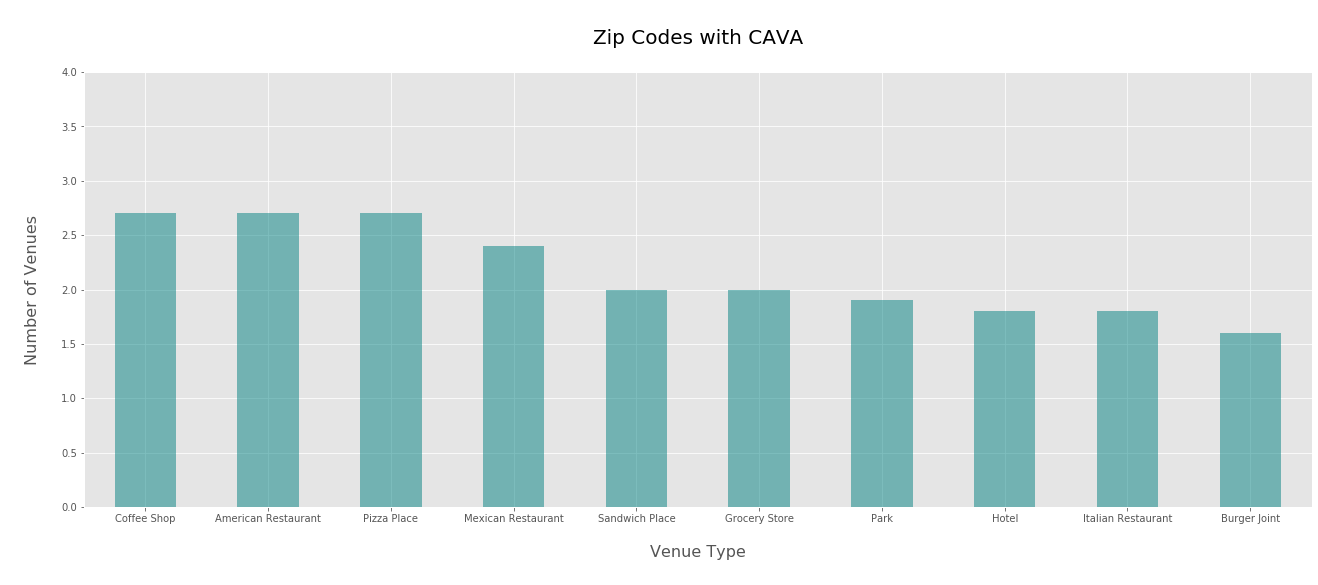

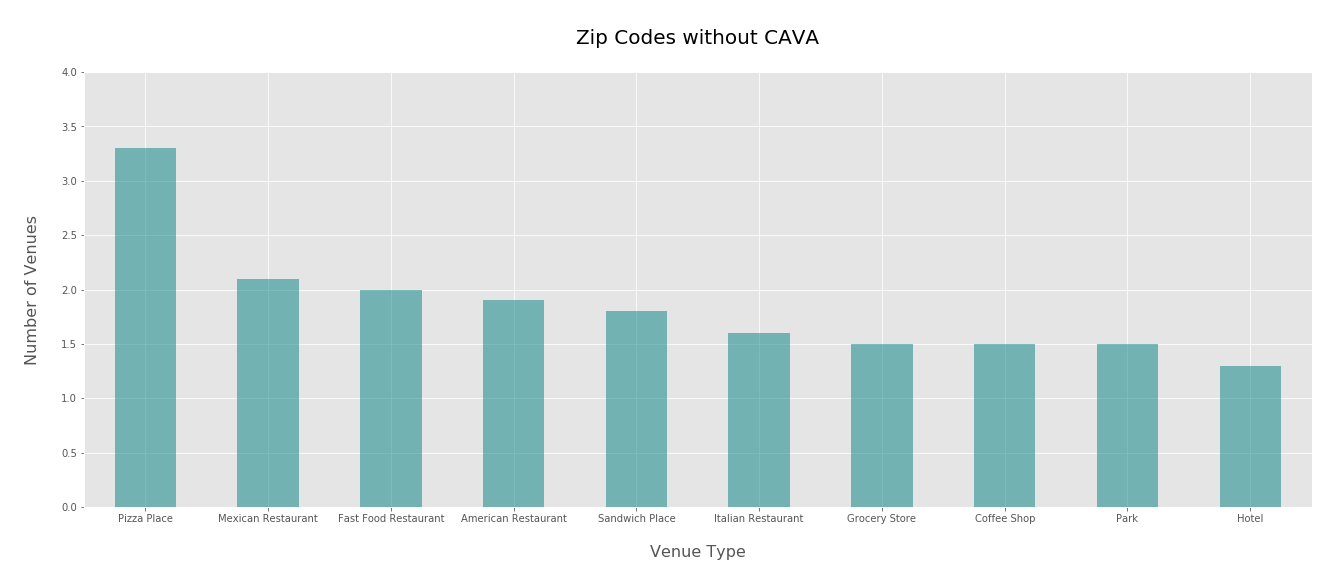

In [36]:
## Bar graph to show most popular venue type in zip codes with CAVA
explore_grouped_cavs.plot(kind = 'bar',
                           figsize = (22,8),
                           align = 'center',
                           color = 'teal',
                           alpha = 0.5,
                           legend = None
                          )

plt.xlabel('\nVenue Type\n', fontsize = 16) # add to x-label to the plot
plt.ylabel('\nNumber of Venues\n', fontsize = 16) # add y-label to the plot
plt.title('\nZip Codes with CAVA\n', fontsize = 20) # add title to the plot
plt.xticks(rotation = 0, fontsize = 10)
plt.ylim(0,4)


## Bar graph to show most popular venue type in zip codes without CAVA
explore_grouped_nocavs.plot(kind = 'bar',
                             figsize = (22,8),
                             align = 'center',
                             color = 'teal',
                             alpha = 0.5,
                             legend = None
                            )

plt.xlabel('\nVenue Type\n', fontsize = 16) # add to x-label to the plot
plt.ylabel('\nNumber of Venues\n', fontsize = 16) # add y-label to the plot
plt.title('\nZip Codes without CAVA\n', fontsize = 20) # add title to the plot
plt.xticks(rotation = 0, fontsize = 10)
plt.ylim(0,4)


plt.show()

#### 

# Drop infrequent variables and collinear variables from training dataset

In [ ]:
##### Import needed libraries

In [37]:
## Standard libraries
import pandas as pd
import numpy as np

## Collinearity assessment library
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Confirm imports
print("\nLibraries imported.\n")


Libraries imported.



In [ ]:
##### Drop infrequent variables that occur in less than 10% of training zip codes, on average

In [39]:
## Load dataset
training_dataset = pd.read_csv('/Users/mitchelllee/cava_coded_grouped_venue_df', dtype = {'Zip Code' : str}).drop('Unnamed: 0', axis = 1)

## Record dataframe shape before drop
print('\nDataframe shape before drop: ', training_dataset.shape, sep = '')

## Drop variables as specified
for col in training_dataset.iloc[:,3:].columns.tolist():
    if sum(training_dataset[col]) < 44:
        training_dataset.drop(col, axis = 1, inplace = True)

## Check dataframe prepped properly
print('Dataframe shape after drop: ', training_dataset.shape, '\n', sep = '')
training_dataset.head()


Dataframe shape before drop: (446, 498)
Dataframe shape after drop: (446, 130)



,Has CAVA?,Zip Code,City,New American Restaurant,Caribbean Restaurant,Pizza Place,Brewery,Cocktail Bar,Gas Station,Pet Store,Gym / Fitness Center,Grocery Store,Pub,Video Store,Beer Garden,Dive Bar,Smoke Shop,Salon / Barbershop,Gourmet Shop,Toy / Game Store,Rental Car Location,Bookstore,Market,Convenience Store,Spa,Shoe Store,Japanese Restaurant,Bank,Playground,Vietnamese Restaurant,Coffee Shop,Thai Restaurant,Dessert Shop,Smoothie Shop,Park,Music Venue,Department Store,Baseball Field,Pharmacy,Supplement Shop,Hotel,Bubble Tea Shop,Deli / Bodega,Golf Course,Museum,Hot Dog Joint,Italian Restaurant,Fast Food Restaurant,Juice Bar,Yoga Studio,Farmers Market,Dog Run,Mediterranean Restaurant,Discount Store,Liquor Store,Shopping Mall,Electronics Store,Latin American Restaurant,Indian Restaurant,Furniture / Home Store,Nightclub,Noodle House,Asian Restaurant,Fried Chicken Joint,French Restaurant,Gastropub,Trail,Turkish Restaurant,Gift Shop,Wine Bar,Wings Joint,Ice Cream Shop,Bowling Alley,Wine Shop,Middle Eastern Restaurant,Clothing Store,Soccer Stadium,Brazilian Restaurant,Video Game Store,Donut Shop,Salad Place,Southern / Soul Food Restaurant,Plaza,Seafood Restaurant,Bagel Shop,Breakfast Spot,Thrift / Vintage Store,Lounge,Korean Restaurant,African Restaurant,Lingerie Store,Sandwich Place,Food Truck,Bakery,Movie Theater,Supermarket,Frozen Yogurt Shop,Sports Bar,Scenic Lookout,Cosmetics Shop,Big Box Store,Steakhouse,Diner,Restaurant,Automotive Shop,Greek Restaurant,Vegetarian / Vegan Restaurant,Hardware Store,Arts & Crafts Store,BBQ Joint,Pool,Chinese Restaurant,Beach,Theater,Gym,Café,Mexican Restaurant,Athletics & Sports,Sushi Restaurant,American Restaurant,Fabric Shop,Shipping Store,Taco Place,Warehouse Store,History Museum,Bar,Burger Joint,Women's Store,Sporting Goods Shop,Mobile Phone Shop
0,0,01040,"Holyoke, MA",0,0,7,0,0,2,0,0,2,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,2,0,1,0,0,0,0,1,0,2,0,0,0,0,0,3,4,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,2,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4,1,0,0,0,1,4,0,0,0,0
1,0,01085,"Westfield, MA",0,0,5,1,0,2,0,2,2,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,2,0,0,0,1,0,1,0,3,1,0,0,0,2,1,0,1,2,0,0,0,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,2,0,0,0,1,0,2,0,0,1,0,0,2,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,0,01201,"Pittsfield, MA",0,0,5,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,1,1,1,2,3,0,0,0,0,0,0,1,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,3,0,1,0,1,1,0,0,0,0,0,2,0,0,0,0,1,0,1,0,1,0,2,1,4,0,0,0,4,1,1,0,0,0,5,0,0,1,0
3,0,01420,"Fitchburg, MA",0,0,3,1,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,1,3,0,0,0,2,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,2,0,0,0,1,0,1,0,0,0,0,0,3,1,0,0,0,1,1,0,0,0,1,1,3,0,0,0,0,0,0,0,2,0,0,1,1,0,0,1,2,0,0,0,0,0,2,1,0,0,0
4,0,01453,"Leominster, MA",0,0,4,0,0,0,0,1,2,0,0,0,0,1,1,0,0,0,0,0,3,0,0,0,0,0,0,2,1,0,0,1,0,1,0,2,0,0,0,0,1,0,0,2,1,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,3,0,1,0,2,0,0,1,1,0,1,0,0,0,0,2,3,0,1,0,2,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
#### Drop collinear variables from dataset

In [40]:
## Define variable to determine whether collinearity elimination should occur (0 = continue, 1 = stop)
keep_going = 0

## Define variable to keep track of progress through iterations
iters_completed = 0

## While needed (because variables with VIF > 2.5 still exist), continue collinearity elimination
while keep_going == 0:

    ## Get dataframe showing VIFs for all venue types that have not yet been dropped
    # create new dataframe
    vif_df = pd.DataFrame()
    # get portion of dataframe related to venue types (variables 0 - 2 are not variable types)
    X = training_dataset.iloc[:,3:] 
    # create variable that records each venue type
    vif_df["Variables"] = X.columns
    # calculate VIF for each venue type and assign as variable in row corresponding to venue type
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    # get sub-dataframe showing only venue types with VIF > 2.5
    vif_drop_vars = vif_df[vif_df['VIF'] > 2.5].sort_values(by = 'VIF', ascending = False)['Variables'].tolist()
    # if there are venue types in that sub-dataframe, elimate the one with the biggest VIF from the training dataframe
    if len(vif_drop_vars) > 0:
        drop_var = vif_drop_vars[0]
        training_dataset.drop(drop_var, axis = 1, inplace = True)
    # if there is no venue with VIF > 2.5, stop processing VIFs
    else:
        keep_going = 1

    # show the number of iterations performed (to demonstrate working program and number of features eliminated)
    iters_completed += 1
    print('Iterations completed: {}'.format(iters_completed), end = '\r')

## Show final resulting training dataset
print('\n\nDataframe shape: ', training_dataset.shape, '\n', sep = '')
training_dataset.head()

Iterations completed: 38

Dataframe shape: (446, 93)



,Has CAVA?,Zip Code,City,Caribbean Restaurant,Brewery,Cocktail Bar,Gas Station,Pub,Beer Garden,Dive Bar,Smoke Shop,Salon / Barbershop,Gourmet Shop,Toy / Game Store,Rental Car Location,Bookstore,Market,Spa,Shoe Store,Japanese Restaurant,Bank,Playground,Vietnamese Restaurant,Thai Restaurant,Dessert Shop,Smoothie Shop,Music Venue,Baseball Field,Supplement Shop,Hotel,Bubble Tea Shop,Deli / Bodega,Golf Course,Museum,Hot Dog Joint,Juice Bar,Farmers Market,Dog Run,Mediterranean Restaurant,Liquor Store,Shopping Mall,Electronics Store,Latin American Restaurant,Indian Restaurant,Nightclub,Noodle House,Fried Chicken Joint,Gastropub,Trail,Gift Shop,Wine Bar,Wings Joint,Bowling Alley,Wine Shop,Middle Eastern Restaurant,Brazilian Restaurant,Video Game Store,Salad Place,Southern / Soul Food Restaurant,Plaza,Bagel Shop,Thrift / Vintage Store,Lounge,Korean Restaurant,Lingerie Store,Food Truck,Movie Theater,Supermarket,Frozen Yogurt Shop,Sports Bar,Scenic Lookout,Big Box Store,Steakhouse,Diner,Restaurant,Automotive Shop,Greek Restaurant,Vegetarian / Vegan Restaurant,Hardware Store,Arts & Crafts Store,BBQ Joint,Pool,Beach,Theater,Athletics & Sports,Sushi Restaurant,Shipping Store,Taco Place,Warehouse Store,History Museum,Women's Store,Sporting Goods Shop,Mobile Phone Shop
0,0,01040,"Holyoke, MA",0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,4,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,01085,"Westfield, MA",0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,2,1,0,0,0,0,0,2,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,1,0,0,2,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,01201,"Pittsfield, MA",0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,2,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,2,0,0,0,0,1,0,1,0,0,2,0,0,1,0,0,0,0,1,0
3,0,01420,"Fitchburg, MA",0,1,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,01453,"Leominster, MA",0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,2,0,0,2,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
##### Save updated training dataframe

In [41]:
## Save dataframe
training_dataset.to_csv('/Users/mitchelllee/cava_training_df')

## Confirm dataframe saved
print('\nDataset saved.\n')


Dataset saved.



#### 

# Develop optimal logistic regression model

In [ ]:
##### Import needed libraries

In [42]:
## Standard libraries
import pandas as pd
import numpy as np

## LogReg model libraries
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm

## Warnings output library
import warnings

## Math library
import math

## Confirm imports
print('\nLibraries imported.\n')


Libraries imported.



In [ ]:
##### Change warning and display settings as is helpful

In [43]:
## Eliminate 'zerodivide' warning
warnings.filterwarnings('ignore')

## Set to show all rows and columns in a dataset
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Confirm setting of options
print('\nOptions set as desired.\n')


Options set as desired.



In [ ]:
##### Prepare the training dataset

In [44]:
## Load training dataset
training_dataset = pd.read_csv('/Users/mitchelllee/cava_training_df').drop('Unnamed: 0', axis = 1)

## Check that dataframe prepped properly
print('\nDataframe shape: ', training_dataset.shape, '\n', sep = '')
training_dataset.sort_values(by = "City").head()


Dataframe shape: (446, 93)



,Has CAVA?,Zip Code,City,Caribbean Restaurant,Brewery,Cocktail Bar,Gas Station,Pub,Beer Garden,Dive Bar,Smoke Shop,Salon / Barbershop,Gourmet Shop,Toy / Game Store,Rental Car Location,Bookstore,Market,Spa,Shoe Store,Japanese Restaurant,Bank,Playground,Vietnamese Restaurant,Thai Restaurant,Dessert Shop,Smoothie Shop,Music Venue,Baseball Field,Supplement Shop,Hotel,Bubble Tea Shop,Deli / Bodega,Golf Course,Museum,Hot Dog Joint,Juice Bar,Farmers Market,Dog Run,Mediterranean Restaurant,Liquor Store,Shopping Mall,Electronics Store,Latin American Restaurant,Indian Restaurant,Nightclub,Noodle House,Fried Chicken Joint,Gastropub,Trail,Gift Shop,Wine Bar,Wings Joint,Bowling Alley,Wine Shop,Middle Eastern Restaurant,Brazilian Restaurant,Video Game Store,Salad Place,Southern / Soul Food Restaurant,Plaza,Bagel Shop,Thrift / Vintage Store,Lounge,Korean Restaurant,Lingerie Store,Food Truck,Movie Theater,Supermarket,Frozen Yogurt Shop,Sports Bar,Scenic Lookout,Big Box Store,Steakhouse,Diner,Restaurant,Automotive Shop,Greek Restaurant,Vegetarian / Vegan Restaurant,Hardware Store,Arts & Crafts Store,BBQ Joint,Pool,Beach,Theater,Athletics & Sports,Sushi Restaurant,Shipping Store,Taco Place,Warehouse Store,History Museum,Women's Store,Sporting Goods Shop,Mobile Phone Shop
239,1,22314,"Alexandria, VA",0,0,0,0,1,0,0,0,0,0,0,0,1,0,3,0,1,0,0,1,2,1,0,0,0,0,3,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0,0,1,0,1,0,0,0,1,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,0
240,1,22315,"Alexandria, VA",0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,0,1,0,1,3,0,1,0,1,0,0,1,2,0,0,0,0,1,0,0,0,3,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,2,1,1,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,2,1,1,0,0,1,0,1
238,1,22305,"Alexandria, VA",0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,1,1,0,1,2,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,2,0,0,1,0,0,1,0,1,0,1,0,0,2,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
237,0,22304,"Alexandria, VA",0,1,0,0,0,1,0,1,1,0,0,0,1,1,2,0,2,1,0,1,2,0,0,1,0,0,5,0,1,0,0,0,0,0,0,1,1,1,0,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,2,1,1,0,0,0,0,0,1,1,0,1,0,0,2,3,0,0,0,0,0,0,0,0,0,0,1,0
143,0,18102,"Allentown, PA",0,2,0,0,2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,3,0,1,1,1,1,0,1,0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,3,2,0,0,0,1,0,1,0,0,2,0,0,0,0,0,1,1,0,0


In [ ]:
##### Optimize a logistic regression model using RFE

In [45]:
## Use RFE selector to pick best variable combination for every possible combination # (i.e., for best combo of 1 variable, of 2 variables, 3 variales, etc.)
## Fit and score logreg model for each best combination (will pick the selected variable combination with the best score)

# Define X and y and preprocess
X = training_dataset.iloc[:,3:]
y = training_dataset['Has CAVA?']
X = preprocessing.StandardScaler().fit(X).transform(X)

# Define predictors in dataset
predictors = training_dataset.iloc[:,3:].columns

# Test using number of features between 1 and the highest maximum for which the selector only picks statistically significant variables
min_features = 1
max_features = 6  # 6 is the highest number of predictors possible before the selector picks a combination that are not all statistically significant

# Define prediction model
reg_mod = LogisticRegression(C = 0.01)

# Make list of scoring for each n number of predictors
logreg_scores_list = []

# Keep track of iteration through number of features tested
completed = 0
total = max_features

# For each number of features to test, find best feature set and score for that feature set
for n in range(min_features, max_features + 1):
    
    # get list of varibles picked by the selector
    selector = RFE(reg_mod, n_features_to_select = n).fit(X, y)
    keep_vars = np.asarray(predictors)[selector.support_]
    
    X_sub = np.asarray(training_dataset[keep_vars])
    X_sub = preprocessing.StandardScaler().fit(X_sub).transform(X_sub)

    # calculate cross-validated score for current set of predictors
    cvs_score = cross_val_score(reg_mod, X = X_sub, y = y, cv = 10)
    score = round(cvs_score.mean(), 2)
    score_95CI_lower = round(score - (cvs_score.std()/math.sqrt(10) * 1.96), 2)
    score_95CI_upper = round(score + (cvs_score.std()/math.sqrt(10) * 1.96), 2)
    
    # calculate cross-validated ppv (precision)
    cvs_prec = cross_val_score(reg_mod, X = X_sub, y = y, cv = 10, scoring = 'precision')
    prec = round(cvs_prec.mean(), 2)
    prec_95CI_lower = round(prec - (cvs_prec.std()/math.sqrt(10) * 1.96), 2)
    prec_95CI_upper = round(prec + (cvs_prec.std()/math.sqrt(10) * 1.96), 2)

    # calculate cross-validated sensitivity (recall)   
    cvs_sense = cross_val_score(reg_mod, X = X_sub, y = y, cv = 10, scoring = 'recall')
    sense = round(cvs_sense.mean(), 2)
    sense_95CI_lower = round(sense - (cvs_sense.std()/math.sqrt(10) * 1.96), 2)
    sense_95CI_upper = round(sense + (cvs_sense.std()/math.sqrt(10) * 1.96), 2)

    # add all values to score list
    logreg_scores_list.append([n, score, score_95CI_lower, score_95CI_upper, prec, prec_95CI_lower, prec_95CI_upper, sense, sense_95CI_lower, sense_95CI_upper, keep_vars])
    
    # show progress through iterations
    completed += 1
    print('Percent completed: {:%}'.format(completed / total), end = '\r')


## Create dataframe of all the evaluation parameters
# Make scoring list into dataframe
logreg_scores_df = pd.DataFrame(logreg_scores_list, columns = ['# Predictors',
                                                               'Score', 'Score Lower 95% CI', 'Score Upper 95% CI',
                                                               'PPV', 'PPV Lower 95% CI', 'PPV Upper 95% CI',
                                                               'Sensitivity', 'Sensitivity Lower 95% CI', 'Sensitivity Upper 95% CI',
                                                               'Predictors'])

## Sort dataframe from highest to lowest in this order of levels in the below order (PPV is most important; Sensitivity is then most important)
logreg_scores_df.sort_values(by = ['PPV Lower 95% CI', 'Sensitivity Lower 95% CI', '# Predictors'], ascending = False, inplace = True)

## Get values from top row after sorting (top row =  best model)
# Get number of predictors for best model
logreg_final_n = logreg_scores_df['# Predictors'].values[0]

# Get cross-validated score for best model
logreg_final_score = logreg_scores_df['Score'].values[0]
logreg_final_score_lower_CI = logreg_scores_df['Score Lower 95% CI'].values[0]
logreg_final_score_upper_CI = logreg_scores_df['Score Upper 95% CI'].values[0]

# Get cross-validated ppv for best model
logreg_final_ppv = logreg_scores_df['PPV'].values[0]
logreg_final_ppv_lower_CI = logreg_scores_df['PPV Lower 95% CI'].values[0]
logreg_final_ppv_upper_CI = logreg_scores_df['PPV Upper 95% CI'].values[0]

# Get cross-validated sensitivity for best model
logreg_final_sense = logreg_scores_df['Sensitivity'].values[0]
logreg_final_sense_lower_CI  = logreg_scores_df['Sensitivity Lower 95% CI'].values[0]
logreg_final_sense_upper_CI = logreg_scores_df['Sensitivity Upper 95% CI'].values[0]

# Get predictors used in optimal model
logreg_final_kept_vars = logreg_scores_df['Predictors'].values[0]


## Print out scoring metrics for optimal model
print('\rPercent completed: 100%                                                     ')

print('\nBest # of predictors:                {}'.format(logreg_final_n))
print()

print('Final cross-validated score:         {}'.format(logreg_final_score))
print('Corresponding lower 95% CI:          {}'.format(logreg_final_score_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(logreg_final_score_upper_CI))
print()

print('Final cross-validated PPV:           {}'.format(logreg_final_ppv))
print('Corresponding lower 95% CI:          {}'.format(logreg_final_ppv_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(logreg_final_ppv_upper_CI))
print()

print('Final cross-validated Sensitivity:   {}'.format(logreg_final_sense))
print('Corresponding lower 95% CI:          {}'.format(logreg_final_sense_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(logreg_final_sense_upper_CI))
print()

print('Best predictors:')
[print(' -x{}:'.format(i+1), pred) for i, pred in enumerate(logreg_final_kept_vars)]
print()

## Show statistical significant of variables used in final best model
X = training_dataset.loc[:,logreg_final_kept_vars]
y = training_dataset['Has CAVA?']
X = preprocessing.StandardScaler().fit(X).transform(X)

fitted_mod = sm.Logit(y, X).fit()

print(fitted_mod.summary2())

## Show scores dataframe
logreg_scores_df.head(10)

Percent completed: 100%                                                     

Best # of predictors:                5

Final cross-validated score:         0.8
Corresponding lower 95% CI:          0.78
Corresponding upper 95% CI:          0.82

Final cross-validated PPV:           0.87
Corresponding lower 95% CI:          0.74
Corresponding upper 95% CI:          1.0

Final cross-validated Sensitivity:   0.17
Corresponding lower 95% CI:          0.11
Corresponding upper 95% CI:          0.23

Best predictors:
 -x1: Gourmet Shop
 -x2: Shopping Mall
 -x3: Fried Chicken Joint
 -x4: Salad Place
 -x5: Sushi Restaurant

Optimization terminated successfully.
         Current function value: 0.572276
         Iterations 6
                        Results: Logit
Model:              Logit            Pseudo R-squared: -0.070  
Dependent Variable: Has CAVA?        AIC:              520.4699
Date:               2020-08-14 20:43 BIC:              540.9715
No. Observations:   446              Log-Likel

,# Predictors,Score,Score Lower 95% CI,Score Upper 95% CI,PPV,PPV Lower 95% CI,PPV Upper 95% CI,Sensitivity,Sensitivity Lower 95% CI,Sensitivity Upper 95% CI,Predictors
4,5,0.80,0.78,0.82,0.87,0.74,1.00,0.17,0.11,0.23,"[Gourmet Shop, Shopping Mall, Fried Chicken Jo..."
5,6,0.80,0.78,0.82,0.84,0.70,0.98,0.18,0.13,0.23,"[Gourmet Shop, Shopping Mall, Fried Chicken Jo..."
2,3,0.80,0.78,0.82,0.85,0.65,1.05,0.14,0.08,0.20,"[Gourmet Shop, Salad Place, Sushi Restaurant]"
3,4,0.80,0.79,0.81,0.77,0.57,0.97,0.14,0.09,0.19,"[Gourmet Shop, Shopping Mall, Salad Place, Sus..."
1,2,0.79,0.77,0.81,0.65,0.37,0.93,0.11,0.05,0.17,"[Gourmet Shop, Salad Place]"
0,1,0.79,0.78,0.80,0.55,0.26,0.84,0.08,0.03,0.13,[Salad Place]


#### 

# Develop optimal SVC model

In [ ]:
##### Import needed packages/libraries

In [46]:
## Standard libraries
import pandas as pd
import numpy as np

## Import needed libraries
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

## Warnings ouput library
import warnings

## Basic math library
import math

## Confirm imports
print('\nLibraries imported.\n')


Libraries imported.



In [ ]:
##### Change settings as need

In [47]:
## Eliminate 'zerodivide' warning
warnings.filterwarnings('ignore')

## Set to show all rows and columns in a dataset
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Confirm options setting
print('\nOptions set as desired.\n')


Options set as desired.



In [ ]:
##### Prepare the data

In [48]:
## Load dataset
training_dataset = pd.read_csv('/Users/mitchelllee/cava_training_df').drop('Unnamed: 0', axis = 1)


## Check that dataframe prepped properly
print('\nDataframe shape: ', training_dataset.shape, '\n', sep = '')
training_dataset.sort_values(by = "City").head()


Dataframe shape: (446, 93)



,Has CAVA?,Zip Code,City,Caribbean Restaurant,Brewery,Cocktail Bar,Gas Station,Pub,Beer Garden,Dive Bar,Smoke Shop,Salon / Barbershop,Gourmet Shop,Toy / Game Store,Rental Car Location,Bookstore,Market,Spa,Shoe Store,Japanese Restaurant,Bank,Playground,Vietnamese Restaurant,Thai Restaurant,Dessert Shop,Smoothie Shop,Music Venue,Baseball Field,Supplement Shop,Hotel,Bubble Tea Shop,Deli / Bodega,Golf Course,Museum,Hot Dog Joint,Juice Bar,Farmers Market,Dog Run,Mediterranean Restaurant,Liquor Store,Shopping Mall,Electronics Store,Latin American Restaurant,Indian Restaurant,Nightclub,Noodle House,Fried Chicken Joint,Gastropub,Trail,Gift Shop,Wine Bar,Wings Joint,Bowling Alley,Wine Shop,Middle Eastern Restaurant,Brazilian Restaurant,Video Game Store,Salad Place,Southern / Soul Food Restaurant,Plaza,Bagel Shop,Thrift / Vintage Store,Lounge,Korean Restaurant,Lingerie Store,Food Truck,Movie Theater,Supermarket,Frozen Yogurt Shop,Sports Bar,Scenic Lookout,Big Box Store,Steakhouse,Diner,Restaurant,Automotive Shop,Greek Restaurant,Vegetarian / Vegan Restaurant,Hardware Store,Arts & Crafts Store,BBQ Joint,Pool,Beach,Theater,Athletics & Sports,Sushi Restaurant,Shipping Store,Taco Place,Warehouse Store,History Museum,Women's Store,Sporting Goods Shop,Mobile Phone Shop
239,1,22314,"Alexandria, VA",0,0,0,0,1,0,0,0,0,0,0,0,1,0,3,0,1,0,0,1,2,1,0,0,0,0,3,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0,0,1,0,1,0,0,0,1,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,0
240,1,22315,"Alexandria, VA",0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,0,1,0,1,3,0,1,0,1,0,0,1,2,0,0,0,0,1,0,0,0,3,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,2,1,1,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,2,1,1,0,0,1,0,1
238,1,22305,"Alexandria, VA",0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,1,1,0,1,2,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,2,0,0,1,0,0,1,0,1,0,1,0,0,2,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
237,0,22304,"Alexandria, VA",0,1,0,0,0,1,0,1,1,0,0,0,1,1,2,0,2,1,0,1,2,0,0,1,0,0,5,0,1,0,0,0,0,0,0,1,1,1,0,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,2,1,1,0,0,0,0,0,1,1,0,1,0,0,2,3,0,0,0,0,0,0,0,0,0,0,1,0
143,0,18102,"Allentown, PA",0,2,0,0,2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,3,0,1,1,1,1,0,1,0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,3,2,0,0,0,1,0,1,0,0,2,0,0,0,0,0,1,1,0,0


In [ ]:
##### Develop the optimal model

In [49]:
## Fit the selector across range of n features

# Define X and y and preprocess
X = training_dataset.loc[:,logreg_final_kept_vars]
y = training_dataset['Has CAVA?']
X = preprocessing.StandardScaler().fit(X).transform(X)

# Define predictors in dataset
predictors = training_dataset.loc[:,logreg_final_kept_vars].columns

# Test using number of features between 1 and all of them
min_features = 1
max_features = len(predictors)  # the model performs poorly after 100 variables

# Define prediction model
svc_mod = SVC(kernel = 'linear')

# Make list of scoring for each n number of predictors
svc_scores_list = []

# Keep track of iteration through number of features tested
completed = 0
total = max_features

# For each number of features to test, find best feature set and score for that feature set
for n in range(min_features, max_features + 1):
    selector = RFE(svc_mod, n_features_to_select = n).fit(X, y)
    keep_vars = np.asarray(predictors[selector.support_])
    
    X_sub = training_dataset[keep_vars]
    X_sub = preprocessing.StandardScaler().fit(X_sub).transform(X_sub)
    
    # calculate cross-validated score for current set of predictors
    cvs_score = cross_val_score(svc_mod, X = X_sub, y = y, cv = 10)
    score = round(cvs_score.mean(), 2)
    score_95CI_lower = round(score - (cvs_score.std()/math.sqrt(10) * 1.96), 2)
    score_95CI_upper = round(score + (cvs_score.std()/math.sqrt(10) * 1.96), 2)
    
    # calculate cross-validated ppv (precision)
    cvs_prec = cross_val_score(svc_mod, X = X_sub, y = y, cv = 10, scoring = 'precision')
    prec = round(cvs_prec.mean(), 2)
    prec_95CI_lower = round(prec - (cvs_prec.std()/math.sqrt(10) * 1.96), 2)
    prec_95CI_upper = round(prec + (cvs_prec.std()/math.sqrt(10) * 1.96), 2)

    # calculate cross-validated sensitivity (recall)   
    cvs_sense = cross_val_score(svc_mod, X = X_sub, y = y, cv = 10, scoring = 'recall')
    sense = round(cvs_sense.mean(), 2)
    sense_95CI_lower = round(sense - (cvs_sense.std()/math.sqrt(10) * 1.96), 2)
    sense_95CI_upper = round(sense + (cvs_sense.std()/math.sqrt(10) * 1.96), 2)

    # add all values to score list
    svc_scores_list.append([n, score, score_95CI_lower, score_95CI_upper, prec, prec_95CI_lower, prec_95CI_upper, sense, sense_95CI_lower, sense_95CI_upper, keep_vars])
    
    completed += 1
    print('Percent completed: {:%}'.format(completed / total), end = '\r')


    
## Create dataframe of all the evaluation parameters
# Make scoring list into dataframe
svc_scores_df = pd.DataFrame(svc_scores_list, columns = ['# Predictors',
                                                         'Score', 'Score Lower 95% CI', 'Score Upper 95% CI',
                                                         'PPV', 'PPV Lower 95% CI', 'PPV Upper 95% CI',
                                                         'Sensitivity', 'Sensitivity Lower 95% CI', 'Sensitivity Upper 95% CI',
                                                         'Predictors'])


## Sort dataframe from highest to lowest in this order of levels in the below order (PPV is most important; Sensitivity is then most important)
svc_scores_df.sort_values(by = ['PPV Lower 95% CI', 'Sensitivity Lower 95% CI', '# Predictors'], ascending = False, inplace = True)


## Get values from top row after sorting (top row =  best model)
# Get number of predictors for best model
svc_final_n = svc_scores_df['# Predictors'].values[0]

# Get cross-validated score for best model
svc_final_score = svc_scores_df['Score'].values[0]
svc_final_score_lower_CI = svc_scores_df['Score Lower 95% CI'].values[0]
svc_final_score_upper_CI = svc_scores_df['Score Upper 95% CI'].values[0]

# Get cross-validated ppv for best model
svc_final_ppv = svc_scores_df['PPV'].values[0]
svc_final_ppv_lower_CI = svc_scores_df['PPV Lower 95% CI'].values[0]
svc_final_ppv_upper_CI = svc_scores_df['PPV Upper 95% CI'].values[0]

# Get cross-validated sensitivity for best model
svc_final_sense = svc_scores_df['Sensitivity'].values[0]
svc_final_sense_lower_CI  = svc_scores_df['Sensitivity Lower 95% CI'].values[0]
svc_final_sense_upper_CI = svc_scores_df['Sensitivity Upper 95% CI'].values[0]

# Get predictors used in optimal model
svc_final_kept_vars = svc_scores_df['Predictors'].values[0]


## Print out scoring metrics for optimal model
print('\rPercent completed: 100%                                                     ')

print('\nBest # of predictors:                {}'.format(svc_final_n))
print()

print('Final cross-validated score:         {}'.format(svc_final_score))
print('Corresponding lower 95% CI:          {}'.format(svc_final_score_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(svc_final_score_upper_CI))
print()

print('Final cross-validated PPV:           {}'.format(svc_final_ppv))
print('Corresponding lower 95% CI:          {}'.format(svc_final_ppv_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(svc_final_ppv_upper_CI))
print()

print('Final cross-validated Sensitivity:   {}'.format(svc_final_sense))
print('Corresponding lower 95% CI:          {}'.format(svc_final_sense_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(svc_final_sense_upper_CI))
print()

print('Best predictors:')
[print(' -', pred) for pred in svc_final_kept_vars]
print()


## Show dataframe
svc_scores_df.head()

Percent completed: 100%                                                     

Best # of predictors:                5

Final cross-validated score:         0.82
Corresponding lower 95% CI:          0.79
Corresponding upper 95% CI:          0.85

Final cross-validated PPV:           0.66
Corresponding lower 95% CI:          0.55
Corresponding upper 95% CI:          0.77

Final cross-validated Sensitivity:   0.44
Corresponding lower 95% CI:          0.34
Corresponding upper 95% CI:          0.54

Best predictors:
 - Gourmet Shop
 - Shopping Mall
 - Fried Chicken Joint
 - Salad Place
 - Sushi Restaurant



,# Predictors,Score,Score Lower 95% CI,Score Upper 95% CI,PPV,PPV Lower 95% CI,PPV Upper 95% CI,Sensitivity,Sensitivity Lower 95% CI,Sensitivity Upper 95% CI,Predictors
4,5,0.82,0.79,0.85,0.66,0.55,0.77,0.44,0.34,0.54,"[Gourmet Shop, Shopping Mall, Fried Chicken Jo..."
3,4,0.82,0.79,0.85,0.66,0.55,0.77,0.44,0.34,0.54,"[Gourmet Shop, Shopping Mall, Fried Chicken Jo..."
2,3,0.82,0.79,0.85,0.66,0.55,0.77,0.44,0.34,0.54,"[Shopping Mall, Fried Chicken Joint, Salad Place]"
1,2,0.82,0.79,0.85,0.66,0.55,0.77,0.44,0.34,0.54,"[Shopping Mall, Salad Place]"
0,1,0.82,0.79,0.85,0.66,0.55,0.77,0.44,0.34,0.54,[Salad Place]


#### 

# Develop optimal KNN model

In [ ]:
#### Import needed libraries

In [50]:
####
## Standard libraries
import pandas as pd
import numpy as np

##
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier

##
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

##
import warnings

##
import math

##
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

print('\nLibraries imported.\n')


Libraries imported.



In [ ]:
##### Change settings to avoid warning messages and improve output formats

In [51]:
## Eliminate 'zerodivide' warning
warnings.filterwarnings('ignore')

####
## Set to show all rows and columns in a dataset
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print('\nOptions set as desired.\n')


Options set as desired.



In [ ]:
##### Load and prepare the data

In [52]:
## Load dataset
training_dataset = pd.read_csv('/Users/mitchelllee/cava_training_df').drop('Unnamed: 0', axis = 1)

## Drop any variable that does not occur for any CAVA location (I think that makes more sense)
grouped_training_df = training_dataset.groupby(by = 'Has CAVA?').sum().drop(0)

for col in grouped_training_df.columns.tolist():
    if grouped_training_df[col].values[0] == 0:
        training_dataset.drop(col, axis = 1, inplace = True)

## Check that dataframe prepped properly
print('\nDataframe shape: ', training_dataset.shape, '\n', sep = '')
training_dataset.head()


Dataframe shape: (446, 93)



,Has CAVA?,Zip Code,City,Caribbean Restaurant,Brewery,Cocktail Bar,Gas Station,Pub,Beer Garden,Dive Bar,Smoke Shop,Salon / Barbershop,Gourmet Shop,Toy / Game Store,Rental Car Location,Bookstore,Market,Spa,Shoe Store,Japanese Restaurant,Bank,Playground,Vietnamese Restaurant,Thai Restaurant,Dessert Shop,Smoothie Shop,Music Venue,Baseball Field,Supplement Shop,Hotel,Bubble Tea Shop,Deli / Bodega,Golf Course,Museum,Hot Dog Joint,Juice Bar,Farmers Market,Dog Run,Mediterranean Restaurant,Liquor Store,Shopping Mall,Electronics Store,Latin American Restaurant,Indian Restaurant,Nightclub,Noodle House,Fried Chicken Joint,Gastropub,Trail,Gift Shop,Wine Bar,Wings Joint,Bowling Alley,Wine Shop,Middle Eastern Restaurant,Brazilian Restaurant,Video Game Store,Salad Place,Southern / Soul Food Restaurant,Plaza,Bagel Shop,Thrift / Vintage Store,Lounge,Korean Restaurant,Lingerie Store,Food Truck,Movie Theater,Supermarket,Frozen Yogurt Shop,Sports Bar,Scenic Lookout,Big Box Store,Steakhouse,Diner,Restaurant,Automotive Shop,Greek Restaurant,Vegetarian / Vegan Restaurant,Hardware Store,Arts & Crafts Store,BBQ Joint,Pool,Beach,Theater,Athletics & Sports,Sushi Restaurant,Shipping Store,Taco Place,Warehouse Store,History Museum,Women's Store,Sporting Goods Shop,Mobile Phone Shop
0,0,1040,"Holyoke, MA",0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,4,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,1085,"Westfield, MA",0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,2,1,0,0,0,0,0,2,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,1,0,0,2,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1201,"Pittsfield, MA",0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,2,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,2,0,0,0,0,1,0,1,0,0,2,0,0,1,0,0,0,0,1,0
3,0,1420,"Fitchburg, MA",0,1,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,1453,"Leominster, MA",0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,2,0,0,2,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#### Train and score the model across a different ks

In [53]:
X = training_dataset.loc[:,logreg_final_kept_vars]
y = training_dataset['Has CAVA?']
X = preprocessing.StandardScaler().fit(X).transform(X)

knn_scores_list = []

completed = 0
total = len(training_dataset.loc[:,logreg_final_kept_vars].columns)

for k in range(1, total):
    
    knn = KNeighborsClassifier(k)
    
    # calculate cross-validated score for current set of predictors
    cvs_score = cross_val_score(knn, X = X_sub, y = y, cv = 10)
    score = round(cvs_score.mean(), 2)
    score_95CI_lower = round(score - (cvs_score.std()/math.sqrt(10) * 1.96), 2)
    score_95CI_upper = round(score + (cvs_score.std()/math.sqrt(10) * 1.96), 2)
    
    # calculate cross-validated ppv (precision)
    cvs_prec = cross_val_score(knn, X = X_sub, y = y, cv = 10, scoring = 'precision')
    prec = round(cvs_prec.mean(), 2)
    prec_95CI_lower = round(prec - (cvs_prec.std()/math.sqrt(10) * 1.96), 2)
    prec_95CI_upper = round(prec + (cvs_prec.std()/math.sqrt(10) * 1.96), 2)

    # calculate cross-validated sensitivity (recall)   
    cvs_sense = cross_val_score(knn, X = X_sub, y = y, cv = 10, scoring = 'recall')
    sense = round(cvs_sense.mean(), 2)
    sense_95CI_lower = round(sense - (cvs_sense.std()/math.sqrt(10) * 1.96), 2)
    sense_95CI_upper = round(sense + (cvs_sense.std()/math.sqrt(10) * 1.96), 2)

    # add all values to score list
    knn_scores_list.append([k, score, score_95CI_lower, score_95CI_upper, prec, prec_95CI_lower, prec_95CI_upper, sense, sense_95CI_lower, sense_95CI_upper])
    
    completed += 1
    print('Percent completed: {:%}'.format(completed / total), end = '\r')

####
## Create dataframe of all the evaluation parameters
# Make scoring list into dataframe
knn_scores_df = pd.DataFrame(knn_scores_list, columns = ['K',
                                                         'Score', 'Score Lower 95% CI', 'Score Upper 95% CI',
                                                         'PPV', 'PPV Lower 95% CI', 'PPV Upper 95% CI',
                                                         'Sensitivity', 'Sensitivity Lower 95% CI', 'Sensitivity Upper 95% CI'])

## Sort dataframe from highest to lowest in this order of levels in the below order (PPV is most important; Sensitivity is then most important)
knn_scores_df.sort_values(by = ['PPV Lower 95% CI', 'Sensitivity Lower 95% CI', 'K'], ascending = False, inplace = True)

## Get values from top row after sorting (top row =  best model)
# Get number of predictors for best model
knn_final_k = knn_scores_df['K'].values[0]

# Get cross-validated score for best model
knn_final_score = knn_scores_df['Score'].values[0]
knn_final_score_lower_CI = knn_scores_df['Score Lower 95% CI'].values[0]
knn_final_score_upper_CI = knn_scores_df['Score Upper 95% CI'].values[0]

# Get cross-validated ppv for best model
knn_final_ppv = knn_scores_df['PPV'].values[0]
knn_final_ppv_lower_CI = knn_scores_df['PPV Lower 95% CI'].values[0]
knn_final_ppv_upper_CI = knn_scores_df['PPV Upper 95% CI'].values[0]

# Get cross-validated sensitivity for best model
knn_final_sense = knn_scores_df['Sensitivity'].values[0]
knn_final_sense_lower_CI  = knn_scores_df['Sensitivity Lower 95% CI'].values[0]
knn_final_sense_upper_CI = knn_scores_df['Sensitivity Upper 95% CI'].values[0]

####
## Print out scoring metrics for optimal model
print('\rPercent completed: 100%                                                     ')

print('\nFinal K:                             {}'.format(knn_final_k))
print()

print('Final cross-validated score:         {}'.format(knn_final_score))
print('Corresponding lower 95% CI:          {}'.format(knn_final_score_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(knn_final_score_upper_CI))
print()

print('Final cross-validated PPV:           {}'.format(knn_final_ppv))
print('Corresponding lower 95% CI:          {}'.format(knn_final_ppv_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(knn_final_ppv_upper_CI))
print()

print('Final cross-validated Sensitivity:   {}'.format(knn_final_sense))
print('Corresponding lower 95% CI:          {}'.format(knn_final_sense_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(knn_final_sense_upper_CI))
print()

#####
## Show dataframe
knn_scores_df.head(10)

Percent completed: 100%                                                     

Final K:                             2

Final cross-validated score:         0.78
Corresponding lower 95% CI:          0.76
Corresponding upper 95% CI:          0.8

Final cross-validated PPV:           0.65
Corresponding lower 95% CI:          0.47
Corresponding upper 95% CI:          0.83

Final cross-validated Sensitivity:   0.16
Corresponding lower 95% CI:          0.11
Corresponding upper 95% CI:          0.21



,K,Score,Score Lower 95% CI,Score Upper 95% CI,PPV,PPV Lower 95% CI,PPV Upper 95% CI,Sensitivity,Sensitivity Lower 95% CI,Sensitivity Upper 95% CI
1,2,0.78,0.76,0.80,0.65,0.47,0.83,0.16,0.11,0.21
0,1,0.78,0.74,0.82,0.54,0.43,0.65,0.33,0.25,0.41
3,4,0.79,0.76,0.82,0.60,0.37,0.83,0.19,0.09,0.29
2,3,0.77,0.73,0.81,0.48,0.32,0.64,0.27,0.16,0.38


#### 

# Report model scores

In [54]:
final_score_report_df = pd.DataFrame([
    
    ['Logistic Regression', logreg_final_n,
     logreg_final_score, logreg_final_score_lower_CI, logreg_final_score_upper_CI,
     logreg_final_ppv, logreg_final_ppv_lower_CI, logreg_final_ppv_upper_CI,
     logreg_final_sense, logreg_final_sense_lower_CI, logreg_final_sense_upper_CI,
     logreg_final_kept_vars
    ],
    
    ['SVC', svc_final_n,
     svc_final_score, svc_final_score_lower_CI,
     svc_final_score_upper_CI,
     svc_final_ppv, svc_final_ppv_lower_CI, svc_final_ppv_upper_CI,
     svc_final_sense, svc_final_sense_lower_CI, svc_final_sense_upper_CI,
     svc_final_kept_vars
    ],
     
    ['KNN', knn_final_k,
     knn_final_score, knn_final_score_lower_CI, knn_final_score_upper_CI,
     knn_final_ppv, knn_final_ppv_lower_CI, knn_final_ppv_upper_CI,
     knn_final_sense, knn_final_sense_lower_CI, knn_final_sense_upper_CI,
     'NA'
    ]],
    
    columns = ['Model', 
               '# Predictors/Neighbors',
               'Final Score', 'Score Lower CI', 'Score Upper CI',
               'Final PPV', 'PPV Lower CI', 'PPV Upper CI',
               'Final Sensitivity', 'Sensitivity Lower CI', 'Sensitivity Upper CI',
               'Final Predictors'
              ]
)
     
     
final_score_report_df

,Model,# Predictors/Neighbors,Final Score,Score Lower CI,Score Upper CI,Final PPV,PPV Lower CI,PPV Upper CI,Final Sensitivity,Sensitivity Lower CI,Sensitivity Upper CI,Final Predictors
0,Logistic Regression,5,0.80,0.78,0.82,0.87,0.74,1.00,0.17,0.11,0.23,"[Gourmet Shop, Shopping Mall, Fried Chicken Jo..."
1,SVC,5,0.82,0.79,0.85,0.66,0.55,0.77,0.44,0.34,0.54,"[Gourmet Shop, Shopping Mall, Fried Chicken Jo..."
2,KNN,2,0.78,0.76,0.80,0.65,0.47,0.83,0.16,0.11,0.21,NA


#### ###
Based on the results above, I will use the SVC model with the variables kept for that model after optimization to predict the viability of new postal codes
as CAVA locations. I will, in particular, test the most populous zip codes in the most populous states that don't have a CAVA.
#### ###

#### 

# Make dataframe with venue data for most populous zip codes in states w/o CAVAs

In [ ]:
#### Import needed libraries

In [56]:
#standard need libraries
import pandas as pd
import numpy as np

print('\nLibraries imported.\n')


Libraries imported.



In [ ]:
#### Load model training location info dataset

In [57]:
## Read dataframe in from personal computer
training_loc_info_df = pd.read_csv('/Users/mitchelllee/cava_combo_loc_info_df', dtype = {'Zip Code':str}).drop('Unnamed: 0', axis = 1)

## Show dataframe shape
print('\nDataframe shape: ', training_loc_info_df.shape, '\n', sep = '')
training_loc_info_df.sort_values('City').head()


Dataframe shape: (446, 5)



,Has CAVA?,Zip Code,City,Latitude,Longitude
92,1,22305,"Alexandria, VA",38.838504,-77.065392
75,1,22314,"Alexandria, VA",38.805057,-77.050220
76,1,22315,"Alexandria, VA",38.759248,-77.158834
437,0,22304,"Alexandria, VA",38.810080,-77.089191
342,0,18104,"Allentown, PA",40.601743,-75.498102


In [ ]:
#### Get list of states without CAVA by population

In [58]:
states_dict = {
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'NC': 'North Carolina',
    'NJ': 'New Jersey',
    'NY': 'New York',
    'PA': 'Pennsylvania',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'VA': 'Virginia'
}

## Get list of states with CAVA
cav_cities = set(training_loc_info_df['City'])
cav_states_abbvs = []
cav_states = []

for city in cav_cities:
    if states_dict[city.split(', ')[-1]] not in cav_states:
        cav_states.append(states_dict[city.split(', ')[-1]])

print('\nStates with CAVA: \n')
[print(state) for state in cav_states]

print('\n')

## Scrape list of states in order by population
states_df = pd.read_html('https://www.infoplease.com/us/states/state-population-by-rank')[0].iloc[:,[1,2]]
states_df.columns = ['State', 'Population']

for i, row in states_df.iterrows():
    if row['State'] in cav_states:
        states_df.drop(i, inplace = True)

# reset index and drop rows corresponding to DC (#36) and meta info (#39) as these rows are not needed
nocav_states_df = states_df.reset_index().drop('index', axis = 1).drop([36,39])
# make state names lowercase and remove spaces for website urls
nocav_states_df['State'] = nocav_states_df['State'].str.lower()

print('States without CAVA: ', nocav_states_df.shape, sep = '')
print('Dataframe shape: ', nocav_states_df.shape, '\n', sep = '')
nocav_states_df


States with CAVA: 

New Jersey
Massachusetts
North Carolina
Texas
Connecticut
Maryland
California
Virginia
Tennessee
Pennsylvania
New York
Colorado
District of Columbia


States without CAVA: (38, 2)
Dataframe shape: (38, 2)



,State,Population
0,florida,21477737
1,illinois,12671821
2,ohio,11689100
3,georgia,10617423
4,michigan,9986857
5,washington,7614893
6,arizona,7278717
7,indiana,6732219
8,missouri,6137428
9,wisconsin,5822434


In [ ]:
#### Make dataframe of zip codes to predict as CAVA locations 

In [60]:
## Create dictionary to convert state names to abbreviations 

# only need first table in website and not 'Abbreviation' column of that table
state_names_abbvs_df = pd.read_html('https://www.infoplease.com/us/postal-information/state-abbreviations-and-state-postal-codes')[0]

# initialize a dictionary
state_names_abbvs_dict = {}
# define key, value pair for each state in dictionary
# make state name all lowercase and remove spaces for later use in urls (which require all lowercase and no spaces)
for i, row in state_names_abbvs_df.iterrows():
    state_names_abbvs_dict[row['State/District'].lower()] = row['Postal Code']

print()
for item in list(state_names_abbvs_dict.items())[0:10]:
    print(item)
print()


('alabama', 'AL')
('alaska', 'AK')
('arizona', 'AZ')
('arkansas', 'AR')
('california', 'CA')
('colorado', 'CO')
('connecticut', 'CT')
('delaware', 'DE')
('district of columbia', 'DC')
('florida', 'FL')



In [61]:
## Get 10 most-populated zip codes in all states without CAVAs

# initialize empty dataset
pred_zip_loc_df = pd.DataFrame()

completed = 0 # used to keep track of progress through below 'for' loop
total = len(nocav_states_df) # used to keep track of progress through below 'for' loop

for state in nocav_states_df['State']:
    
    # get 10 biggest zip codes by population in the state from a website
    state_name_v1 = ''.join(state.split(' ')) #remove space from state name for url
    postals = pd.read_html('https://www.{}-demographics.com/zip_codes_by_population'.format(state_name_v1))[0][['Zip Code']].head(10)
    # make zip code 'string' type
    postals['Zip Code'] = postals['Zip Code'].astype(str)
    
    # get cities corresponding to all zip codes in the state
    state_name_v2 = '-'.join(state.split(' ')) # replace space with '-' in state name for url
    postal_cits = pd.read_html('https://www.zipdatamaps.com/list-of-zip-codes-in-{}.php'.format(state_name_v2))[0][['Zip Code', 'Zip Code Name']]
    # update city names to include state abbreviation using 'state_names_abbvs_dict' created above
    postal_cits['Zip Code Name'] = postal_cits['Zip Code Name'] + ', {}'.format(state_names_abbvs_dict[state])
    # make city names strings
    postal_cits['Zip Code'] = postal_cits['Zip Code'].astype(str)

    # use merge method to add corresponding city names to biggest zip codes in state ID'ed by line 14
    postals = postals.merge(postal_cits, on = 'Zip Code', how = 'inner')
    
    # add identified zip codes for current state to dataframe of all zip codes to predict as CAVA locations
    pred_zip_loc_df = pred_zip_loc_df.append(postals)

    # update and print progress reporter
    completed += 1
    print('Percent completed: {}%'.format(round(completed/total*100, 2)), end = '\r')
    
print()
print('\nDataframe shape: ', pred_zip_loc_df.shape, '\n', sep = '')
pred_zip_loc_df.head()

Percent completed: 100.0%

Dataframe shape: (379, 2)



,Zip Code,Zip Code Name
0,33012,"Hialeah, FL"
1,33024,"Hollywood, FL"
2,33023,"Hollywood, FL"
3,33311,"Fort Lauderdale, FL"
4,33025,"Hollywood, FL"


In [ ]:
#### Add variables for prediction and coordinates

In [62]:
pred_zip_loc_df['Latitude'] = ['-'] * len(pred_zip_loc_df)
pred_zip_loc_df['Longitude'] = ['-'] * len(pred_zip_loc_df)
pred_zip_loc_df['Prediction'] = ['-'] * len(pred_zip_loc_df)

pred_zip_loc_df = pred_zip_loc_df[['Prediction', 'Zip Code', 'Zip Code Name', 'Latitude', 'Longitude']]

pred_zip_loc_df.columns = ['Prediction', 'Zip Code', 'City', 'Latitude', 'Longitude']

print('\nDataframe shape: ', pred_zip_loc_df.shape, '\n', sep = '')
pred_zip_loc_df.head()


Dataframe shape: (379, 5)



,Prediction,Zip Code,City,Latitude,Longitude
0,-,33012,"Hialeah, FL",-,-
1,-,33024,"Hollywood, FL",-,-
2,-,33023,"Hollywood, FL",-,-
3,-,33311,"Fort Lauderdale, FL",-,-
4,-,33025,"Hollywood, FL",-,-


In [ ]:
#### Get coordinate date for each row

In [65]:
## Import needed libraries
from opencage.geocoder import OpenCageGeocode

## Define geocoding credentials
zip_geocoder = OpenCageGeocode(key = '2cc2ff6d1fa14099b8a24d469f4fd038')

## Get coordinate data
total_items = len(pred_zip_loc_df)
completed_items = 0

for i, row in pred_zip_loc_df.iterrows():
    
    input_address = ', '.join([row['City'].split(',')[-1], row['Zip Code']])
    
    location = zip_geocoder.geocode(query = input_address)
    row['Latitude'] = location[0]['geometry']['lat']
    row['Longitude'] = location[0]['geometry']['lng']
    
    completed_items += 1
    print('Percent complete: {}%'.format(round(completed_items/total_items*100, 3)), end = '\r')

print('\nDataframe Shape: ', pred_zip_loc_df.shape, '\n', sep = '')
pred_zip_loc_df.sort_values(by = 'City').head()



Dataframe Shape: (379, 5)



,Prediction,Zip Code,City,Latitude,Longitude
4,-,57401,"Aberdeen, SD",45.4488,-98.4547
0,-,87121,"Albuquerque, NM",38.3892,45.684
1,-,87114,"Albuquerque, NM",38.3892,45.684
2,-,87120,"Albuquerque, NM",35.1232,-106.708
3,-,87105,"Albuquerque, NM",35.017,-106.683


In [ ]:
#### Get venue data for coordinates using explore endpoint

In [66]:
### ### ###
def getNearbyVenuesExplore(desigs, cities, postals, latitudes, longitudes, radius, LIMIT):
    
    venues_list=[]
    
    total = len(desigs)
    completed = 0
    
    for desig, city, postal, lat, lng in zip(desigs, cities, postals, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()['response']['groups'][0]['items']
        except KeyError:
            results = []
        
        # return only relevant information for each nearby venue
        for v in results:
            try:
                venues_list.append([desig,
                                    city,
                                    postal,
                                    lat,
                                    lng,
                                    v['venue']['name'],
                                    v['venue']['categories'][0]['name']])
            except KeyError:
                pass
        
        #show progress as percentage of 'result' output processed
        completed += 1
        print('Percent completed: {}%'.format(round(completed/total*100, 2)), end = '\r')
        

    #make 'venues_list' into a dataframe        
    nearby_vens = pd.DataFrame(venues_list)
    nearby_vens.columns = ['Has CAVA?',
                           'City',
                           'Zip Code',
                           'Latitude',
                           'Longitude',
                           'Venue',
                           'Venue Category']
    
    return(nearby_vens)

### ### ###

In [ ]:
##### Get venue data for coordinates using 'explore' endpoint

In [67]:
## Import library
import requests

## Define FourSquare credentials
CLIENT_ID = 'C5TVLNNOZ3QX14URLNVGVXAKYHOT421V0KR21MSGVJY1O2CR' # my Foursquare ID
CLIENT_SECRET = 'BCTZ4WTEUPUZWKQO0RBRZQZUJ3QDSXV1Y2BKIW5VGUP32M2H' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

## Get venues for prediction dataframe
pred_near_vens_df = getNearbyVenuesExplore(pred_zip_loc_df['Prediction'],
                                                pred_zip_loc_df['City'],
                                                pred_zip_loc_df['Zip Code'],
                                                pred_zip_loc_df['Latitude'],
                                                pred_zip_loc_df['Longitude'],
                                                3200,
                                                100
                                               )


print('\r                            ')
print('Processing completed.')
print('\nDataframe shape: ', pred_near_vens_df.shape, '\n', sep = '')   
pred_near_vens_df.head(10)

                            
Processing completed.

Dataframe shape: (25698, 7)



,Has CAVA?,City,Zip Code,Latitude,Longitude,Venue,Venue Category
0,-,"Hialeah, FL",33012,25.858381,-80.306045,Barbie Bakery,Bakery
1,-,"Hialeah, FL",33012,25.858381,-80.306045,Sarussi,Sandwich Place
2,-,"Hialeah, FL",33012,25.858381,-80.306045,Palacios de Los Jugos,Cuban Restaurant
3,-,"Hialeah, FL",33012,25.858381,-80.306045,Di Piazza Italian Restraurant,Italian Restaurant
4,-,"Hialeah, FL",33012,25.858381,-80.306045,Pincho Man,Food Truck
5,-,"Hialeah, FL",33012,25.858381,-80.306045,Chico's Family Restaurant,Cuban Restaurant
6,-,"Hialeah, FL",33012,25.858381,-80.306045,Krispy Kreme,Donut Shop
7,-,"Hialeah, FL",33012,25.858381,-80.306045,Menchie's,Frozen Yogurt Shop
8,-,"Hialeah, FL",33012,25.858381,-80.306045,Best Buy,Electronics Store
9,-,"Hialeah, FL",33012,25.858381,-80.306045,Starbucks,Coffee Shop


In [ ]:
##### Save dataframe

In [68]:
## Save dataframe
pred_near_vens_df.to_csv('/Users/mitchelllee/cava_uncoded_pred_df')

## Confirm save
print('\nDataframe saved.\n')


Dataframe saved.



In [ ]:
#### Onehot coding of venues

In [69]:
## Load dataframe
pred_near_vens_df = pd.read_csv('/Users/mitchelllee/cava_uncoded_pred_df', dtype = {'Zip Code':str}).drop('Unnamed: 0', axis = 1)

## Show dataframe and its shape
print('\nDataframe shape: ', pred_near_vens_df.shape, '\n', sep = '')   
pred_near_vens_df.head()


Dataframe shape: (25698, 7)



,Has CAVA?,City,Zip Code,Latitude,Longitude,Venue,Venue Category
0,-,"Hialeah, FL",33012,25.858381,-80.306045,Barbie Bakery,Bakery
1,-,"Hialeah, FL",33012,25.858381,-80.306045,Sarussi,Sandwich Place
2,-,"Hialeah, FL",33012,25.858381,-80.306045,Palacios de Los Jugos,Cuban Restaurant
3,-,"Hialeah, FL",33012,25.858381,-80.306045,Di Piazza Italian Restraurant,Italian Restaurant
4,-,"Hialeah, FL",33012,25.858381,-80.306045,Pincho Man,Food Truck


In [70]:
## Perform onehot coding
pred_near_vens_onehot_df = pd.get_dummies(pred_near_vens_df[['Venue Category']], prefix = "", prefix_sep="")

## Add in zip code variable
pred_near_vens_onehot_df['Zip Code'] = pred_near_vens_df['Zip Code']

try:
    pred_near_vens_onehot_df.drop('City', axis = 1, inplace = True)
except KeyError:
    pass

## Show dataframe and its shape
print('\nDataframe shape: ', pred_near_vens_onehot_df.shape, '\n', sep = '')   
pred_near_vens_onehot_df.head(10)


Dataframe shape: (25698, 487)



,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bathing Area,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Bosnian Restaurant,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Castle,Cemetery,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Football Field,College Gym,College Hockey Rink,College Library,College Quad,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Country Dance Club,Coworking Space,Credit Union,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Distribution Center,Dive Bar,Dive Shop,Dive Spot,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fireworks Store,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hunting Supply,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Inn,Insurance Office,Internet Cafe,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Lawyer,Library,Light Rail Station,Lighthouse,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Marijuana Dispensary,Market,Martial Arts School,Massage 

In [ ]:
#### Group venue data by zip code

In [71]:
## Group dataframe by zip code
pred_near_vens_onehot_grouped_df = pred_near_vens_onehot_df.groupby(by = 'Zip Code').sum()

## Use merge to add city and prediction variables to grouped dataframe
pred_near_vens_onehot_grouped_df = pred_near_vens_onehot_grouped_df.merge(pred_zip_loc_df, on = 'Zip Code', how = 'inner')
pred_near_vens_onehot_grouped_df.head()

## Reorder columns for easy of dataframe interpretation
ord_cols = list(set(pred_near_vens_onehot_grouped_df.columns.tolist()) - set(['Zip Code', 'City', 'Prediction']))
ord_cols = ['Prediction','Zip Code', 'City'] + ord_cols
pred_near_vens_onehot_grouped_df = pred_near_vens_onehot_grouped_df[ord_cols] 

## Show dataframe and its shape
print('\nDataframe shape: ', pred_near_vens_onehot_grouped_df.shape, '\n', sep = '')   
pred_near_vens_onehot_grouped_df.head(10)


Dataframe shape: (367, 491)



,Prediction,Zip Code,City,Modern European Restaurant,Harbor / Marina,Stadium,Bike Shop,Argentinian Restaurant,New American Restaurant,Forest,Track,Tanning Salon,Light Rail Station,Taiwanese Restaurant,Caribbean Restaurant,Pizza Place,Medical Center,Recreation Center,College Library,Eye Doctor,Brewery,Cocktail Bar,Food Service,Gas Station,Pet Store,Gym / Fitness Center,Resort,College Stadium,Grocery Store,Zoo Exhibit,Radio Station,ATM,Pub,Travel Agency,Military Base,Video Store,Food Court,Beer Garden,Dive Bar,Smoke Shop,Salon / Barbershop,Airport Lounge,Indie Movie Theater,Cheese Shop,Film Studio,Gourmet Shop,Tennis Stadium,Toy / Game Store,Empanada Restaurant,Rental Car Location,Basketball Stadium,Gay Bar,Library,Scandinavian Restaurant,Hawaiian Restaurant,Bookstore,College Hockey Rink,Market,Rental Service,College Rec Center,Strip Club,Country Dance Club,Gaming Cafe,Heliport,Climbing Gym,Golf Driving Range,Convenience Store,Spa,Hookah Bar,Construction & Landscaping,Tailor Shop,Afghan Restaurant,Bistro,Candy Store,Shoe Store,Spanish Restaurant,Marijuana Dispensary,Fish Market,Japanese Restaurant,Train Station,Bank,Outlet Store,Playground,Print Shop,Laser Tag,Vietnamese Restaurant,Piano Bar,Paintball Field,Coffee Shop,Arepa Restaurant,Thai Restaurant,Event Service,Bosnian Restaurant,College Theater,College Quad,South Indian Restaurant,Intersection,Flea Market,Whisky Bar,Dessert Shop,Hotel Bar,Smoothie Shop,Tour Provider,Cemetery,Chocolate Shop,Cafeteria,Elementary School,Other Repair Shop,Airport Service,Park,Toll Plaza,Bathing Area,Gun Shop,Kebab Restaurant,Music Venue,Dim Sum Restaurant,College Basketball Court,School,Mountain,Palace,Department Store,Baseball Field,Pharmacy,College Administrative Building,Supplement Shop,Hotel,Massage Studio,University,Cajun / Creole Restaurant,Outlet Mall,Bubble Tea Shop,Middle School,Deli / Bodega,Winery,College Gym,Golf Course,Martial Arts School,Museum,Arts & Entertainment,Hot Dog Joint,North Indian Restaurant,Butcher,Community Center,Lake,Italian Restaurant,Go Kart Track,Fast Food Restaurant,Baby Store,Mattress Store,Juice Bar,Trade School,Baseball Stadium,Soccer Field,Roller Rink,Yoga Studio,Convention Center,Farmers Market,Dog Run,Boxing Gym,Home Service,Falafel Restaurant,Skating Rink,Dry Cleaner,Kids Store,Opera House,Stables,Sculpture Garden,Child Care Service,Planetarium,Dive Shop,Food & Drink Shop,Hunting Supply,Ski Chalet,Soup Place,Tattoo Parlor,Theme Park Ride / Attraction,Herbs & Spices Store,Mediterranean Restaurant,Factory,Distillery,Volleyball Court,Paper / Office Supplies Store,Ethiopian Restaurant,Perfume Shop,Discount Store,Liquor Store,Tapas Restaurant,Alternative Healer,Shopping Mall,Knitting Store,Bowling Green,Neighborhood,Electronics Store,Science Museum,Theme Restaurant,Public Art,Beer Store,Latin American Restaurant,Fish & Chips Shop,Indonesian Restaurant,Indian Restaurant,Theme Park,Cultural Center,Furniture / Home Store,Organic Grocery,Rest Area,Veterinarian,Airport,College Auditorium,Men's Store,Nightclub,Moving Target,Fair,Cantonese Restaurant,Pet Café,Noodle House,Recording Studio,Asian Restaurant,Inn,Airport Terminal,Fried Chicken Joint,Garden,French Restaurant,Motorcycle Shop,Gastropub,Truck Stop,Flower Shop,Trail,Turkish Restaurant,Waterfront,German Restaurant,Gift Shop,Wine Bar,Wings Joint,Bridge,Szechuan Restaurant,River,Business Service,Ice Cream Shop,Field,Wine Shop,Bowling Alley,Middle Eastern Restaurant,Mini Golf,Clothing Store,Gymnastics Gym,Record Shop,Jewelry Store,Outdoors & Recreation,Insurance Office,Nature Preserve,Post Office,Office,Art Museum,Rock Club,Soccer Stadium,Arcade,Brazilian Restaurant,Shoe Repair,Video Game Store,General Travel,Bridal Shop,Outdoor Supply Store,Optical Shop,Photography Lab,Bike Trail,Surf Spot,Border Crossing,South American Restaurant,Coworking Space,Donut Shop,Cuban Restaurant,Photography Studio,Colombian Restaurant,Pedestrian Plaza,Health & Beauty Service,Street Art,Lawyer,Shabu-Shabu Restaurant,Church,Cupcake Sho

In [ ]:
#### Visualize most common venues in the prediction dataset

In [72]:
## Import needed libraries

from matplotlib import pyplot as plt
import matplotlib as mpl

mpl.style.use('ggplot') # optional: for ggplot-like style

%matplotlib inline

print('\nLibraries imported.\n')

print ('Matplotlib version: ', mpl.__version__, '\n') # >= 2.0.0



Libraries imported.

Matplotlib version:  3.1.3 



In [74]:
## Transpose the dataframe for bar graph
vis_df = pred_near_vens_onehot_grouped_df.groupby(by = 'Prediction').mean().round(1).sort_values(by = '-', axis = 1, ascending = False).iloc[:,0:10]
vis_df = vis_df.transpose()
vis_df

Prediction,-
Pizza Place,3.4
Fast Food Restaurant,2.9
Coffee Shop,2.7
Sandwich Place,2.7
Mexican Restaurant,2.5
American Restaurant,2.3
Pharmacy,1.5
Grocery Store,1.5
Bar,1.4
Ice Cream Shop,1.4


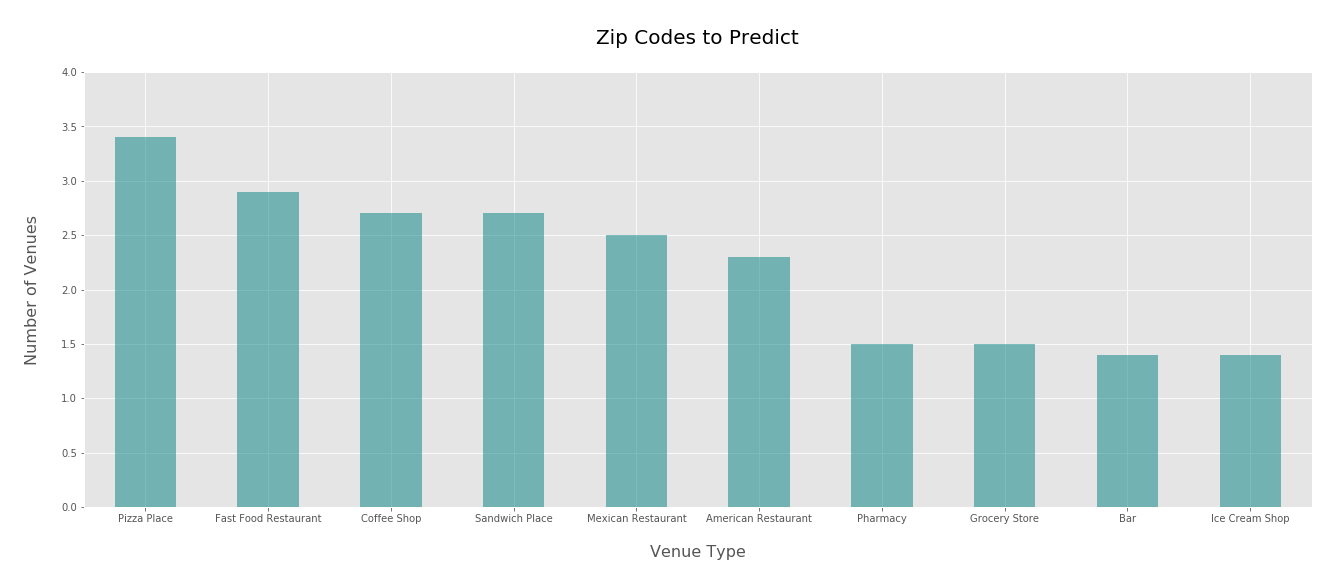

In [75]:
## Bar graph showing most popular venue type in prediction dataframe
vis_df.plot(kind = 'bar',
            figsize = (22,8),
            align = 'center',
            color = 'teal',
            alpha = 0.5,
            legend = None
           )

plt.xlabel('\nVenue Type\n', fontsize = 16) # add to x-label to the plot
plt.ylabel('\nNumber of Venues\n', fontsize = 16) # add y-label to the plot
plt.title('\nZip Codes to Predict\n', fontsize = 20) # add title to the plot
plt.xticks(rotation = 0, fontsize = 10)
plt.ylim(0,4)

print()
plt.show()

In [ ]:
#### Save dataframe to personal computer

In [76]:
## Save dataframe
pred_near_vens_onehot_grouped_df.to_csv('/Users/mitchelllee/cava_pred_df')

## Confirm save
print('\nDataframe saved.')


Dataframe saved.


#### 

# Predict CAVA success in new zip Codes with optimum SVC model

In [ ]:
## Load needed libraries

In [77]:
## Standard libraries
import pandas as pd
import numpy as np

## SVC libraries
from sklearn import preprocessing
from sklearn.svm import SVC

## Confirm imports
print('\nLibraries imported.\n')


Libraries imported.



In [ ]:
#### Load dataset to predict

In [79]:
## Read in dataframe
prediction_df = pd.read_csv('/Users/mitchelllee/cava_pred_df').drop('Unnamed: 0', axis = 1)

## Show dataframe and its shape
print('\nDataframe shape: ', prediction_df.shape, '\n', sep = '')   
prediction_df.head()


Dataframe shape: (367, 491)



,Prediction,Zip Code,City,Modern European Restaurant,Harbor / Marina,Stadium,Bike Shop,Argentinian Restaurant,New American Restaurant,Forest,Track,Tanning Salon,Light Rail Station,Taiwanese Restaurant,Caribbean Restaurant,Pizza Place,Medical Center,Recreation Center,College Library,Eye Doctor,Brewery,Cocktail Bar,Food Service,Gas Station,Pet Store,Gym / Fitness Center,Resort,College Stadium,Grocery Store,Zoo Exhibit,Radio Station,ATM,Pub,Travel Agency,Military Base,Video Store,Food Court,Beer Garden,Dive Bar,Smoke Shop,Salon / Barbershop,Airport Lounge,Indie Movie Theater,Cheese Shop,Film Studio,Gourmet Shop,Tennis Stadium,Toy / Game Store,Empanada Restaurant,Rental Car Location,Basketball Stadium,Gay Bar,Library,Scandinavian Restaurant,Hawaiian Restaurant,Bookstore,College Hockey Rink,Market,Rental Service,College Rec Center,Strip Club,Country Dance Club,Gaming Cafe,Heliport,Climbing Gym,Golf Driving Range,Convenience Store,Spa,Hookah Bar,Construction & Landscaping,Tailor Shop,Afghan Restaurant,Bistro,Candy Store,Shoe Store,Spanish Restaurant,Marijuana Dispensary,Fish Market,Japanese Restaurant,Train Station,Bank,Outlet Store,Playground,Print Shop,Laser Tag,Vietnamese Restaurant,Piano Bar,Paintball Field,Coffee Shop,Arepa Restaurant,Thai Restaurant,Event Service,Bosnian Restaurant,College Theater,College Quad,South Indian Restaurant,Intersection,Flea Market,Whisky Bar,Dessert Shop,Hotel Bar,Smoothie Shop,Tour Provider,Cemetery,Chocolate Shop,Cafeteria,Elementary School,Other Repair Shop,Airport Service,Park,Toll Plaza,Bathing Area,Gun Shop,Kebab Restaurant,Music Venue,Dim Sum Restaurant,College Basketball Court,School,Mountain,Palace,Department Store,Baseball Field,Pharmacy,College Administrative Building,Supplement Shop,Hotel,Massage Studio,University,Cajun / Creole Restaurant,Outlet Mall,Bubble Tea Shop,Middle School,Deli / Bodega,Winery,College Gym,Golf Course,Martial Arts School,Museum,Arts & Entertainment,Hot Dog Joint,North Indian Restaurant,Butcher,Community Center,Lake,Italian Restaurant,Go Kart Track,Fast Food Restaurant,Baby Store,Mattress Store,Juice Bar,Trade School,Baseball Stadium,Soccer Field,Roller Rink,Yoga Studio,Convention Center,Farmers Market,Dog Run,Boxing Gym,Home Service,Falafel Restaurant,Skating Rink,Dry Cleaner,Kids Store,Opera House,Stables,Sculpture Garden,Child Care Service,Planetarium,Dive Shop,Food & Drink Shop,Hunting Supply,Ski Chalet,Soup Place,Tattoo Parlor,Theme Park Ride / Attraction,Herbs & Spices Store,Mediterranean Restaurant,Factory,Distillery,Volleyball Court,Paper / Office Supplies Store,Ethiopian Restaurant,Perfume Shop,Discount Store,Liquor Store,Tapas Restaurant,Alternative Healer,Shopping Mall,Knitting Store,Bowling Green,Neighborhood,Electronics Store,Science Museum,Theme Restaurant,Public Art,Beer Store,Latin American Restaurant,Fish & Chips Shop,Indonesian Restaurant,Indian Restaurant,Theme Park,Cultural Center,Furniture / Home Store,Organic Grocery,Rest Area,Veterinarian,Airport,College Auditorium,Men's Store,Nightclub,Moving Target,Fair,Cantonese Restaurant,Pet Café,Noodle House,Recording Studio,Asian Restaurant,Inn,Airport Terminal,Fried Chicken Joint,Garden,French Restaurant,Motorcycle Shop,Gastropub,Truck Stop,Flower Shop,Trail,Turkish Restaurant,Waterfront,German Restaurant,Gift Shop,Wine Bar,Wings Joint,Bridge,Szechuan Restaurant,River,Business Service,Ice Cream Shop,Field,Wine Shop,Bowling Alley,Middle Eastern Restaurant,Mini Golf,Clothing Store,Gymnastics Gym,Record Shop,Jewelry Store,Outdoors & Recreation,Insurance Office,Nature Preserve,Post Office,Office,Art Museum,Rock Club,Soccer Stadium,Arcade,Brazilian Restaurant,Shoe Repair,Video Game Store,General Travel,Bridal Shop,Outdoor Supply Store,Optical Shop,Photography Lab,Bike Trail,Surf Spot,Border Crossing,South American Restaurant,Coworking Space,Donut Shop,Cuban Restaurant,Photography Studio,Colombian Restaurant,Pedestrian Plaza,Health & Beauty Service,Street Art,Lawyer,Shabu-Shabu Restaurant,Church,Cupcake Sho

In [ ]:
#### Test if new zip venue dataframe contains every variable used in optimum SVC model
# if present, make prediction_df have only those variables

In [80]:
## Take list of final predictors returned from svc predictor optimization segment of this doc
prediction_df = prediction_df[['Prediction','Zip Code', 'City'] + svc_final_kept_vars.tolist()]

## Show dataframe and its shape
print('\nDataframe shape: ', prediction_df.shape, '\n', sep = '')   
prediction_df.head()


Dataframe shape: (367, 8)



,Prediction,Zip Code,City,Gourmet Shop,Shopping Mall,Fried Chicken Joint,Salad Place,Sushi Restaurant
0,-,2816,"Coventry, RI",0,1,1,0,1
1,-,2860,"Pawtucket, RI",0,0,0,0,0
2,-,2864,"Cumberland, RI",0,0,0,0,0
3,-,2893,"West Warwick, RI",0,1,1,0,1
4,-,2904,"Providence, RI",0,0,0,0,0


In [ ]:
##### Train SVC model as optimized earlier

In [81]:
## Load training dataset
training_df = pd.read_csv('cava_training_df').drop('Unnamed: 0', axis = 1)

## Show dataframe and its shape
print('\nDataframe shape: ', training_df.shape, '\n', sep = '')   
training_df.head()


Dataframe shape: (446, 93)



,Has CAVA?,Zip Code,City,Caribbean Restaurant,Brewery,Cocktail Bar,Gas Station,Pub,Beer Garden,Dive Bar,Smoke Shop,Salon / Barbershop,Gourmet Shop,Toy / Game Store,Rental Car Location,Bookstore,Market,Spa,Shoe Store,Japanese Restaurant,Bank,Playground,Vietnamese Restaurant,Thai Restaurant,Dessert Shop,Smoothie Shop,Music Venue,Baseball Field,Supplement Shop,Hotel,Bubble Tea Shop,Deli / Bodega,Golf Course,Museum,Hot Dog Joint,Juice Bar,Farmers Market,Dog Run,Mediterranean Restaurant,Liquor Store,Shopping Mall,Electronics Store,Latin American Restaurant,Indian Restaurant,Nightclub,Noodle House,Fried Chicken Joint,Gastropub,Trail,Gift Shop,Wine Bar,Wings Joint,Bowling Alley,Wine Shop,Middle Eastern Restaurant,Brazilian Restaurant,Video Game Store,Salad Place,Southern / Soul Food Restaurant,Plaza,Bagel Shop,Thrift / Vintage Store,Lounge,Korean Restaurant,Lingerie Store,Food Truck,Movie Theater,Supermarket,Frozen Yogurt Shop,Sports Bar,Scenic Lookout,Big Box Store,Steakhouse,Diner,Restaurant,Automotive Shop,Greek Restaurant,Vegetarian / Vegan Restaurant,Hardware Store,Arts & Crafts Store,BBQ Joint,Pool,Beach,Theater,Athletics & Sports,Sushi Restaurant,Shipping Store,Taco Place,Warehouse Store,History Museum,Women's Store,Sporting Goods Shop,Mobile Phone Shop
0,0,1040,"Holyoke, MA",0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,4,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,1085,"Westfield, MA",0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,2,1,0,0,0,0,0,2,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,1,0,0,2,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1201,"Pittsfield, MA",0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,2,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,2,0,0,0,0,1,0,1,0,0,2,0,0,1,0,0,0,0,1,0
3,0,1420,"Fitchburg, MA",0,1,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,1453,"Leominster, MA",0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,2,0,0,2,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [83]:
## Retrain model as optimized

# Prep segments of dataframe for training
X_train = training_df.loc[:,svc_final_kept_vars]
y_train = training_df['Has CAVA?']
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)

pred_mod = SVC(kernel = 'linear')
pred_mod = pred_mod.fit(X_train, y_train)

print('\nModel fitted.\n')

# Calculate cross-validated score for current set of predictors
cvs_score = cross_val_score(pred_mod, X = X_train, y = y_train, cv = 10)
score = round(cvs_score.mean(), 2)
score_95CI_lower = round(score - (cvs_score.std()/math.sqrt(10) * 1.96), 2)
score_95CI_upper = round(score + (cvs_score.std()/math.sqrt(10) * 1.96), 2)
    
# Calculate cross-validated ppv (precision)
cvs_prec = cross_val_score(pred_mod, X = X_train, y = y_train, cv = 10, scoring = 'precision')
prec = round(cvs_prec.mean(), 2)
prec_95CI_lower = round(prec - (cvs_prec.std()/math.sqrt(10) * 1.96), 2)
prec_95CI_upper = round(prec + (cvs_prec.std()/math.sqrt(10) * 1.96), 2)

# Calculate cross-validated sensitivity (recall)   
cvs_sense = cross_val_score(pred_mod, X = X_train, y = y_train, cv = 10, scoring = 'recall')
sense = round(cvs_sense.mean(), 2)
sense_95CI_lower = round(sense - (cvs_sense.std()/math.sqrt(10) * 1.96), 2)
sense_95CI_upper = round(sense + (cvs_sense.std()/math.sqrt(10) * 1.96), 2)

## Print out training results
print('\rPercent completed: 100%                                                          ')

print('\nBest K:                              {}'.format(svc_final_n))
print()

print('Final cross-validated score:         {}'.format(score))
print('Corresponding lower 95% CI:          {}'.format(score_95CI_lower))
print('Corresponding upper 95% CI:          {}'.format(score_95CI_upper))
print()

print('Final cross-validated PPV:           {}'.format(prec))
print('Corresponding lower 95% CI:          {}'.format(prec_95CI_lower))
print('Corresponding upper 95% CI:          {}'.format(prec_95CI_upper))
print()

print('Final cross-validated Sensitivity:   {}'.format(sense))
print('Corresponding lower 95% CI:          {}'.format(sense_95CI_lower))
print('Corresponding upper 95% CI:          {}'.format(sense_95CI_upper))
print()


Model fitted.

Percent completed: 100%                                                          

Best K:                              5

Final cross-validated score:         0.82
Corresponding lower 95% CI:          0.79
Corresponding upper 95% CI:          0.85

Final cross-validated PPV:           0.66
Corresponding lower 95% CI:          0.55
Corresponding upper 95% CI:          0.77

Final cross-validated Sensitivity:   0.44
Corresponding lower 95% CI:          0.34
Corresponding upper 95% CI:          0.54



In [ ]:
##### Use prediction model to predict if new zip are good CAVA locations

In [86]:
prediction_df['Prediction'] = pred_mod.predict(prediction_df.iloc[:, 3:])

print('\nDataframe shape: ', prediction_df.shape, '\n', sep = '')
prediction_df.sort_values(by = 'Prediction', ascending = False).head(10)


Dataframe shape: (367, 8)



,Prediction,Zip Code,City,Gourmet Shop,Shopping Mall,Fried Chicken Joint,Salad Place,Sushi Restaurant
83,1,33025,"Hollywood, FL",0,0,0,1,0
44,1,19713,"Newark, DE",0,1,2,2,0
40,1,19701,"Bear, DE",0,0,2,1,0
42,1,19709,"Middletown, DE",0,0,0,1,0
285,1,83709,"Boise, ID",0,1,1,2,1
284,1,83704,"Boise, ID",0,1,0,2,1
350,1,98115,"Seattle, WA",0,0,0,1,1
257,1,73013,"Edmond, OK",0,0,0,1,0
47,1,19808,"Wilmington, DE",0,0,0,1,0
246,0,71111,"Bossier City, LA",0,0,0,0,0
